# Imports

In [3]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd

import numpy as np

import os
from scipy.sparse import csr_matrix, vstack

# Data Prep

## Load Data

In [131]:
data = pd.read_csv("./fnb_datav2.csv")

# Remove 
data = data.drop(columns = ["item_descrip"])
data.head(10)
display(data[data['item']== 'EBIB'])


,idcol,interaction,int_date,item,page,tod,item_type,item_descrip,segment,beh_segment,active_ind
5026,1806650,CHECKOUT,09FEB2023,EBIB,Screen1,Morning,LIFESTYLE,EBUCKS AUDIO LIBRARY,segment1,B01,Semi Active
5027,1806650,CLICK,09FEB2023,EBIB,Screen1,Morning,LIFESTYLE,EBUCKS AUDIO LIBRARY,segment1,B01,Semi Active
7160,2670387,CLICK,01FEB2023,EBIB,Screen1,Afternoon,LIFESTYLE,EBUCKS AUDIO LIBRARY,segment3,B01,Cold Start
7161,2670387,CHECKOUT,01FEB2023,EBIB,Screen1,Afternoon,LIFESTYLE,EBUCKS AUDIO LIBRARY,segment3,B01,Cold Start
8105,3132807,CHECKOUT,17MAR2023,EBIB,Screen1,Morning,LIFESTYLE,EBUCKS AUDIO LIBRARY,segment3,B01,Semi Active
...,...,...,...,...,...,...,...,...,...,...,...
396888,25383500918,CLICK,03FEB2023,EBIB,Screen1,Afternoon,LIFESTYLE,EBUCKS AUDIO LIBRARY,segment1,B18,Cold Start
397769,25459157618,CHECKOUT,16MAR2023,EBIB,Screen2,Evening,LIFESTYLE,EBUCKS AUDIO LIBRARY,segment1,B01,Semi Active
397770,25459157618,CLICK,16MAR2023,EBIB,Screen2,Evening,LIFESTYLE,EBUCKS AUDIO LIBRARY,segment1,B01,Semi Active
398299,25504675118,CLICK,03JAN2023,EBIB,Screen2,Early,LIFESTYLE,EBUCKS AUDIO LIBRARY,segment1,B01,Active


# feature engineering

## Item features

In [6]:
# Define the user columns, item columns and interaction columns:
u_cols = ["idcol", "segment", "beh_segment", "active_ind", "most_clicked_item", "most_bought_item",
          "most_clicked_item_type", "most_bought_item_type", "daily_activity_score", "activity_rate"] # TODO Include the checlout-click ratio if useful
# u_cols = ["idcol", "segment", "beh_segment", "active_ind", "avg_daily_freq", "avg_weekly_freq", "avg_monthly_freq"]
item_cols = ["item_id", "item", "item_type", "most_bought_by_beh_seg", "most_bought_by_seg", "most_clicked_by_beh_seg",
             "most_clicked_by_seg", "item_checkout_click_ratio"]
interact_cols = ["idcol", "item_id", "interaction_scores"] # I include idcol and item for now, to basically say "this user did this item with this score at this date"


### probability of segment types choosing an item
- NONE items are not counted
- (item count per segment-None)/(total item count per segment-None)
- 4 features ==> seg1, seg2 etc. with probability of that item being chosen by that segment

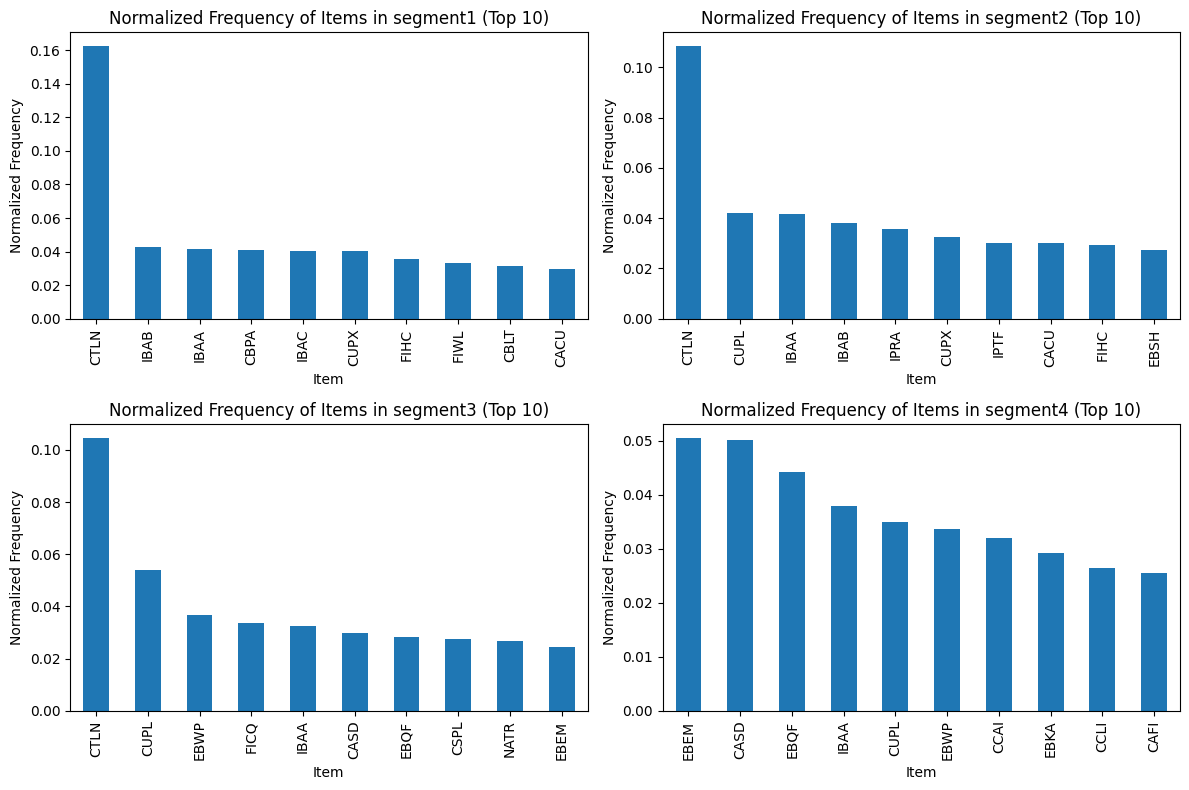

In [14]:
# PER SEGMENT
import matplotlib.pyplot as plt
# Sort unique segment values in ascending order
sorted_items = sorted(data['segment'].unique())

# Create a figure and axis objects for subplots
fig, axs = plt.subplots(2, 2, figsize=(12, 8))  # 2 rows, 2 columns

# Iterate over sorted segments and corresponding subplot axes
for item, ax in zip(sorted_items, axs.flatten()):
    # Filter the data to include only rows where 'segment' is equal to the current segment and remove any NONE items
    item_seg_data = data[(data['segment'] == item)& (data['item'] != 'NONE')]
    
    # Calculate the frequency of each 'item_descrip' for the segment
    item_counts = item_seg_data['item'].value_counts()
    
    # Get the top 10 'item_descrip' based on the total frequency
    top_10_item_beh = item_counts.nlargest(10).index
    
    # Filter the item_descrip_counts series to include only the top 10 'item_descrip'
    top_10_item_counts = item_counts.loc[top_10_item_beh]
    
    # Calculate the total count of all 'item_descrip' entries for the segment
    total_item_count = item_seg_data['item'].count()
    
    # Normalize the frequency of each 'item_descrip' by the total number of all 'item_descrip' entries for the segment
    normalized_top_10_item_counts = top_10_item_counts.div(total_item_count)
    
    # Plot the normalized frequency of 'item_descrip' for the top 10 'item_descrip' for the current segment
    normalized_top_10_item_counts.plot(kind='bar', ax=ax)
    ax.set_xlabel('Item')
    ax.set_ylabel('Normalized Frequency')
    ax.set_title(f'Normalized Frequency of Items in {item} (Top 10)')

plt.tight_layout()
plt.show()

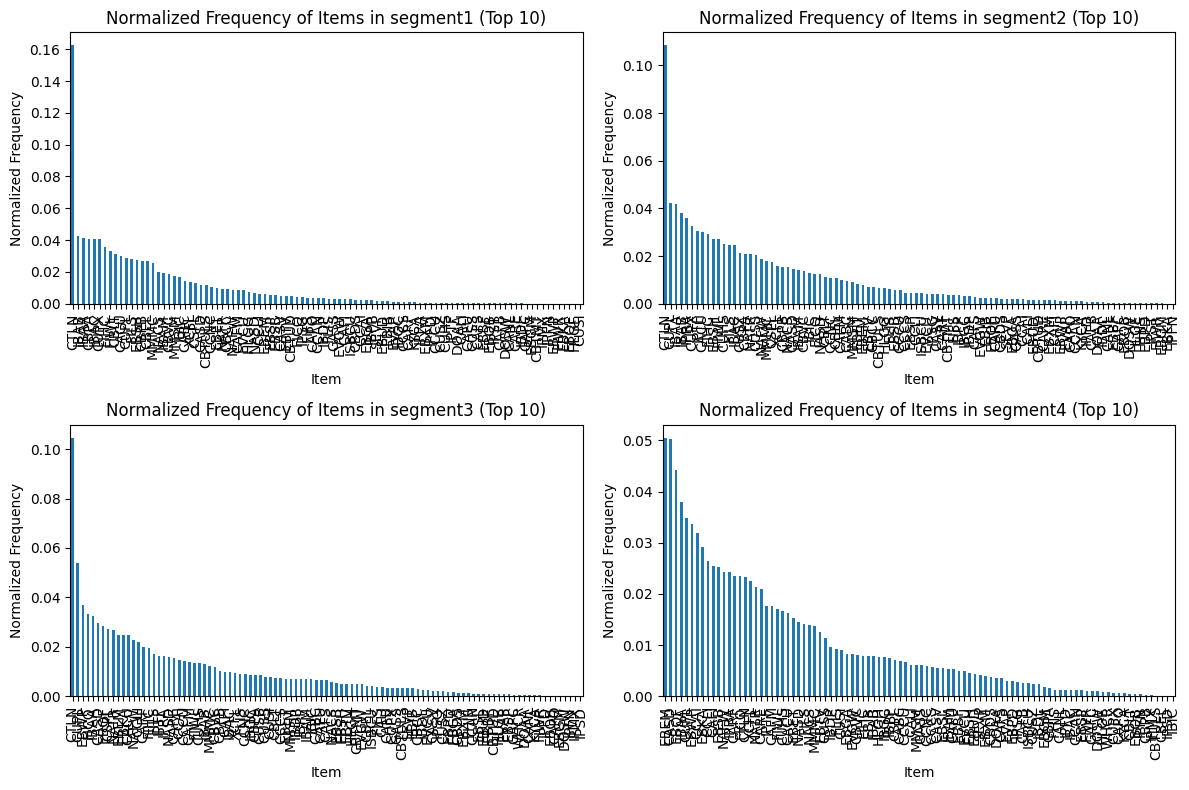

,idcol,interaction,int_date,item,page,tod,item_type,segment,beh_segment,active_ind,segment1,segment2,segment3,segment4
4,4521,CLICK,05FEB2023,IBAB,Screen1,Afternoon,INSURE,segment1,B07,Semi Active,0.042873,0.037911,0.012892,0.007770
5,4521,CHECKOUT,05FEB2023,IBAB,Screen1,Afternoon,INSURE,segment1,B07,Semi Active,0.042873,0.037911,0.012892,0.007770
16,14454,CLICK,08FEB2023,CAFM,Screen2,Morning,TRANSACT,segment2,B01,Active,0.008641,0.010084,0.013896,0.017649
17,14454,CHECKOUT,08FEB2023,CAFM,Screen2,Morning,TRANSACT,segment2,B01,Active,0.008641,0.010084,0.013896,0.017649
18,15000,CLICK,31JAN2023,CARF,Screen2,Morning,LEND,segment3,B01,Cold Start,0.000840,0.003926,0.019792,0.023477
19,15000,CHECKOUT,31JAN2023,CARF,Screen2,Morning,LEND,segment3,B01,Cold Start,0.000840,0.003926,0.019792,0.023477
26,22924,CLICK,26FEB2023,FIWL,Screen1,Morning,INVEST,segment2,B01,Active,0.032953,0.027162,0.013589,0.017039
27,22924,CHECKOUT,26FEB2023,FIWL,Screen1,Morning,INVEST,segment2,B01,Active,0.032953,0.027162,0.013589,0.017039
37,23484,CHECKOUT,22FEB2023,CUSS,Screen1,Afternoon,INVEST,segment2,B01,Cold Start,0.000290,0.020361,0.007920,0.011433
38,23484,CLICK,22FEB2023,CUSS,Screen1,Afternoon,INVEST,segment2,B01,Cold Start,0.000290,0.020361,0.007920,0.011433


In [147]:
# #ADD to data
# # Define the number of segments

# data = pd.read_csv("./fnb_datav2.csv")

# # Remove 
# data = data.drop(columns = ["item_descrip"])
# # Sort unique segment values in ascending order
# sorted_items = sorted(data['segment'].unique())
# # Create a figure and axis objects for subplots
# fig, axs = plt.subplots(2, 2, figsize=(12, 8))  # 2 rows, 2 columns

# # Iterate over sorted segments and corresponding subplot axes
# for item, ax in zip(sorted_items, axs.flatten()):
#     # Filter the data to include only rows where 'segment' is equal to the current segment and remove any NONE items
#     item_seg_data = data[(data['segment'] == item)& (data['item'] != 'NONE')]
    
#     # Calculate the frequency of each 'item_descrip' for the segment
#     item_counts = item_seg_data['item'].value_counts()
    
#     # Calculate the total count of all 'item_descrip' entries for the segment
#     total_item_count = item_seg_data['item'].count()
    
#     # Normalize the frequency of each 'item_descrip' by the total number of all 'item_descrip' entries for the segment
#     normalized_item_counts = item_counts.div(total_item_count)
    
#     # Plot the normalized frequency of 'item_descrip' for the top 10 'item_descrip' for the current segment
#     normalized_item_counts.plot(kind='bar', ax=ax)
#     ax.set_xlabel('Item')
#     ax.set_ylabel('Normalized Frequency')
#     ax.set_title(f'Normalized Frequency of Items in {item} (Top 10)')

# plt.tight_layout()
# plt.show()

# num_segments = 4


# sorted_segs = sorted(data['segment'].unique())
# for seg in sorted_segs:
#     #print(seg)
#     item_seg_data = data[(data['segment'] == seg)& (data['item'] != 'NONE')]
#     #display(item_seg_data['item'].unique)
#         # Calculate the frequency of each 'item_descrip' for the segment
#     item_counts = item_seg_data['item'].value_counts()
#     #print(item_counts)
#         # Calculate the total count of all 'item_descrip' entries for the segment
#     total_item_count = item_seg_data['item'].count()
#     #print(total_item_count)
#         # Normalize the frequency of each 'item_descrip' by the total number of all 'item_descrip' entries for the segment
#     normalized_item_counts = item_counts.div(total_item_count)#.fillnan(0)


#     # Create a new feature column to store the normalized frequencies for each item
#     data[seg] = data['item'].map(normalized_item_counts)
# data[data['item'] != 'NONE'].head(30)
# data[data['segment1'] != 'NaN'].head(10)





#ADD to data
# Define the number of segments

# Sort unique segment values in ascending order
sorted_items = sorted(data['segment'].unique())
# Create a figure and axis objects for subplots
fig, axs = plt.subplots(2, 2, figsize=(12, 8))  # 2 rows, 2 columns

# Iterate over sorted segments and corresponding subplot axes
for item, ax in zip(sorted_items, axs.flatten()):
    # Filter the data to include only rows where 'segment' is equal to the current segment and remove any NONE items
    item_seg_data = data[(data['segment'] == item)& (data['item'] != 'NONE')]
    
    # Calculate the frequency of each 'item_descrip' for the segment
    item_counts = item_seg_data['item'].value_counts()
    
    # Calculate the total count of all 'item_descrip' entries for the segment
    total_item_count = item_seg_data['item'].count()
    
    # Normalize the frequency of each 'item_descrip' by the total number of all 'item_descrip' entries for the segment
    normalized_item_counts = item_counts.div(total_item_count)
    
    # Plot the normalized frequency of 'item_descrip' for the top 10 'item_descrip' for the current segment
    normalized_item_counts.plot(kind='bar', ax=ax)
    ax.set_xlabel('Item')
    ax.set_ylabel('Normalized Frequency')
    ax.set_title(f'Normalized Frequency of Items in {item} (Top 10)')

plt.tight_layout()
plt.show()

num_segments = 4


data = pd.read_csv("./fnb_datav2.csv")

# Remove 
data = data.drop(columns = ["item_descrip"])
sorted_segs = sorted(data['segment'].unique())
for seg in sorted_segs:
    #print(seg)
    item_seg_data = data[(data['segment'] == seg)& (data['item'] != 'NONE')]
    #display(item_seg_data['item'].unique)
        # Calculate the frequency of each 'item_descrip' for the segment
    item_counts = item_seg_data['item'].value_counts()
    #print(item_counts)
        # Calculate the total count of all 'item_descrip' entries for the segment
    total_item_count = item_seg_data['item'].count()
    #print(total_item_count)
        # Normalize the frequency of each 'item_descrip' by the total number of all 'item_descrip' entries for the segment
    normalized_item_counts = item_counts.div(total_item_count).fillna(0)


    # Create a new feature column to store the normalized frequencies for each item
    data[seg] = data['item'].map(normalized_item_counts)
data[data['item'] != 'NONE'].head(30)
#data[data['segment1'] != 'NaN'].head(10)


### Unique users segment scores

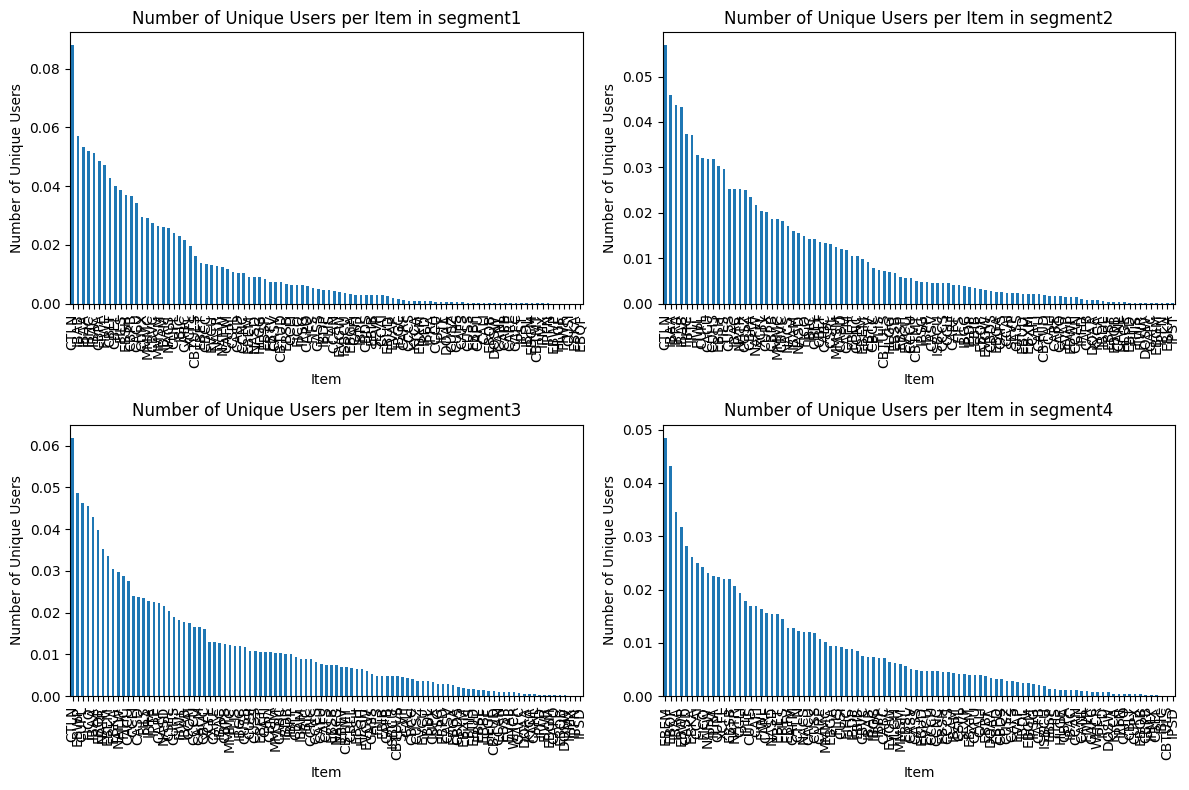

In [155]:

data = pd.read_csv("./fnb_datav2.csv")

# Remove 
data = data.drop(columns = ["item_descrip"])
sorted_segs = sorted(data['segment'].unique())
# Calculate the number of unique users in each segment
unique_users_per_segment = data.groupby('segment')['idcol'].nunique()

# Initialize a dictionary to store the normalized number of unique users for each item within each segment
unique_users_per_item_per_segment = {}

# Iterate over sorted segments
for segment in sorted_segs:
    # Filter the data to include only rows where 'segment' is equal to the current segment and remove any 'NONE' items
    item_seg_data = data[(data['segment'] == segment) & (data['item'] != 'NONE')]
    
    # Calculate the number of unique users for each item
    unique_users_per_item = item_seg_data.groupby('item')['idcol'].nunique().sort_values(ascending=False)
    
    # Normalize the number of unique users for each item by the total number of unique users in the segment
    normalized_unique_users_per_item = unique_users_per_item / unique_users_per_segment[segment]
    
    # Store the normalized number of unique users for each item within the segment
    unique_users_per_item_per_segment[segment] = normalized_unique_users_per_item
    
    # Create a new feature column to store the normalized frequencies for each item within the segment
    data[segment] = data['item'].map(unique_users_per_item_per_segment[segment])

# Display the DataFrame
data[data['item'] != 'NONE'].head(30)


# Create subplots
fig, axs = plt.subplots(2, 2, figsize=(12, 8))

# Iterate over sorted segments and corresponding subplot axes
for segment, ax in zip(sorted_items, axs.flatten()):
    # Retrieve the number of unique users for each item within the segment
    unique_users_per_item = unique_users_per_item_per_segment[segment]
    
    # Plot the number of unique users for each item, sorted from large to small values
    unique_users_per_item.plot(kind='bar', ax=ax)
    ax.set_xlabel('Item')
    ax.set_ylabel('Number of Unique Users')
    ax.set_title(f'Number of Unique Users per Item in {segment}')
    # ax.invert_yaxis()  # Invert y-axis to sort from large to small values

plt.tight_layout()
plt.show()


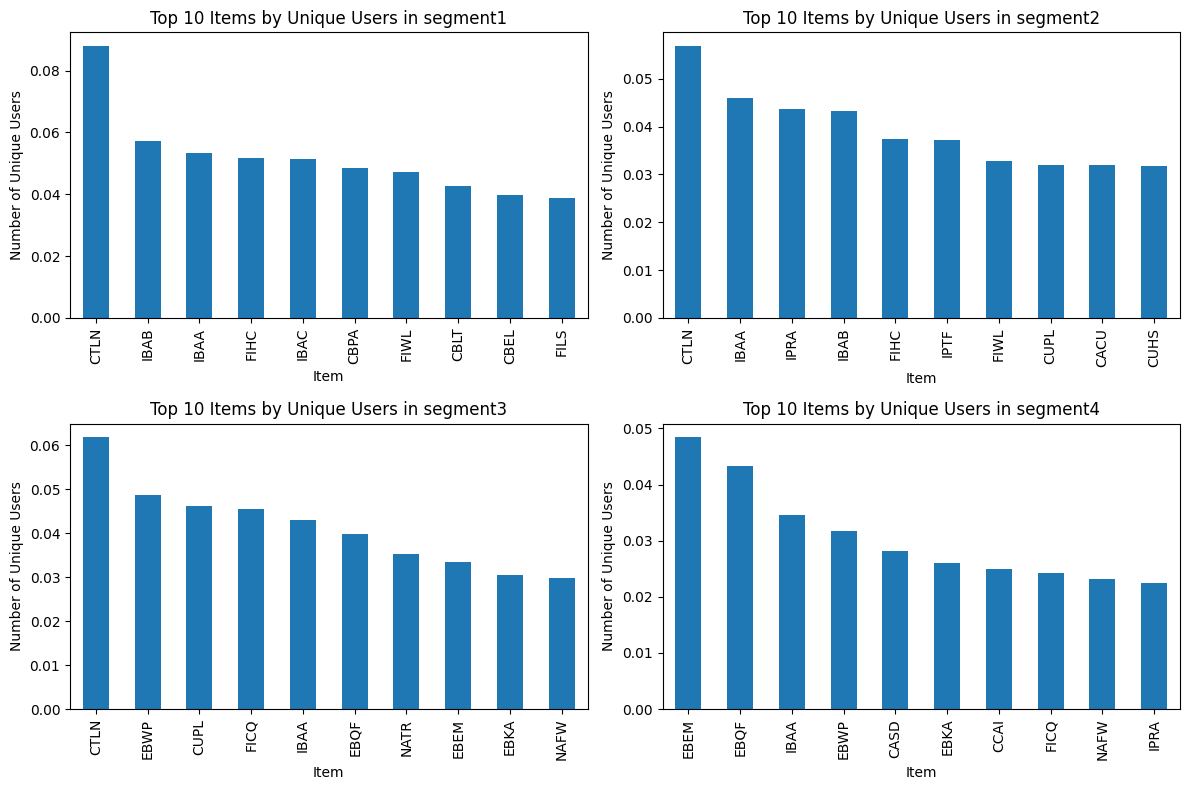

In [148]:
# Calculate the number of unique users in each segment
unique_users_per_segment = data.groupby('segment')['idcol'].nunique()

# Calculate the number of unique users for each item within each segment
unique_users_per_item_per_segment = {}

for segment in sorted_items:
    # Filter the data to include only rows where 'segment' is equal to the current segment and remove any 'NONE' items
    item_seg_data = data[(data['segment'] == segment) & (data['item'] != 'NONE')]
    
    # Calculate the number of unique users for each item
    unique_users_per_item = item_seg_data.groupby('item')['idcol'].nunique().sort_values(ascending=False)
    
    # Normalize the number of unique users for each item by the total number of unique users in the segment
    normalized_unique_users_per_item = unique_users_per_item / unique_users_per_segment[segment]
    
    # Store the normalized number of unique users for each item within the segment
    unique_users_per_item_per_segment[segment] = normalized_unique_users_per_item

# Create subplots
fig, axs = plt.subplots(2, 2, figsize=(12, 8))

# Iterate over sorted segments and corresponding subplot axes
for segment, ax in zip(sorted_items, axs.flatten()):
    # Retrieve the number of unique users for each item within the segment
    unique_users_per_item = unique_users_per_item_per_segment[segment]
    
    # Select the top 10 items
    top_10_items = unique_users_per_item.head(10)
    
    # Plot the number of unique users for each top 10 item, sorted from large to small values
    top_10_items.plot(kind='bar', ax=ax)
    ax.set_xlabel('Item')
    ax.set_ylabel('Number of Unique Users')
    ax.set_title(f'Top 10 Items by Unique Users in {segment}')

plt.tight_layout()
plt.show()

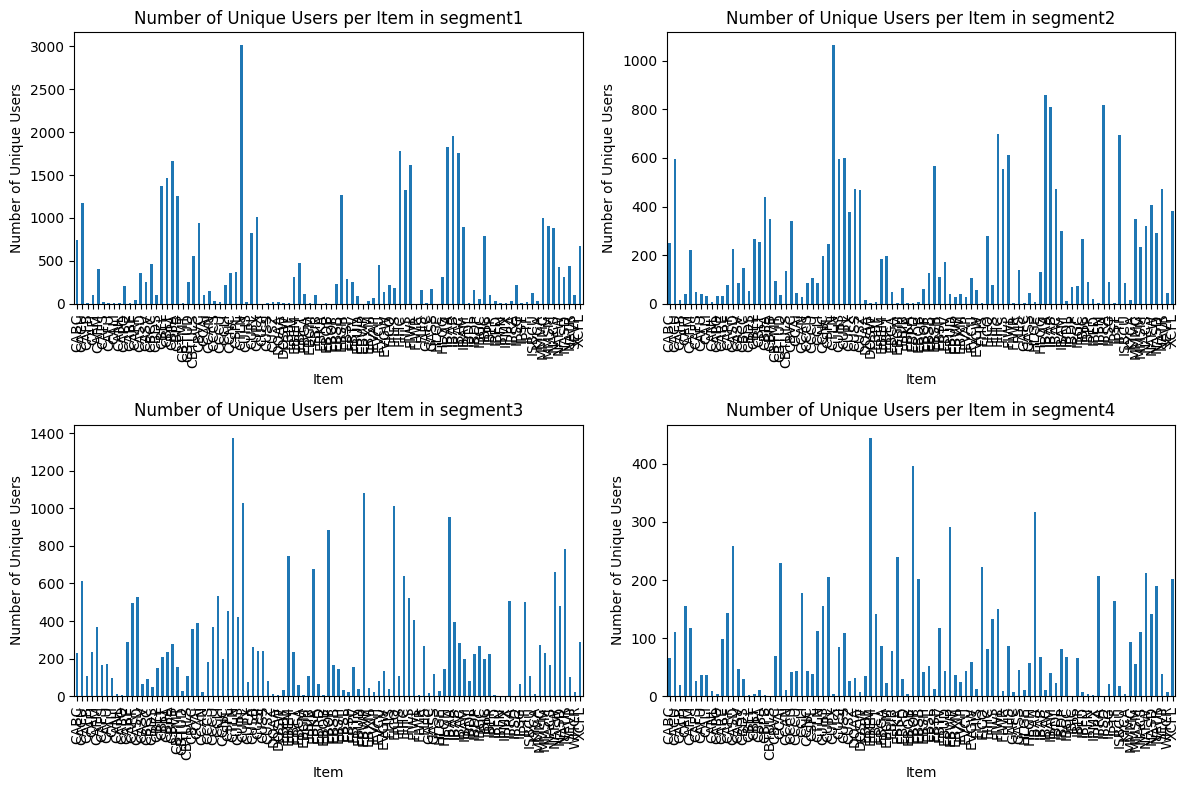

In [132]:

# Calculate the number of unique users for each item within each segment
unique_users_per_item_per_segment = {}

for segment in sorted_items:
    # Filter the data to include only rows where 'segment' is equal to the current segment and remove any 'NONE' items
    item_seg_data = data[(data['segment'] == segment) & (data['item'] != 'NONE')]
    
    # Calculate the number of unique users for each item
    unique_users_per_item = item_seg_data.groupby('item')['idcol'].nunique()
    
    # Store the number of unique users for each item within the segment
    unique_users_per_item_per_segment[segment] = unique_users_per_item

# Create subplots
fig, axs = plt.subplots(2, 2, figsize=(12, 8))

# Iterate over sorted segments and corresponding subplot axes
for segment, ax in zip(sorted_items, axs.flatten()):
    # Retrieve the number of unique users for each item within the segment
    unique_users_per_item = unique_users_per_item_per_segment[segment]
    
    # Plot the number of unique users for each item
    unique_users_per_item.plot(kind='bar', ax=ax)
    ax.set_xlabel('Item')
    ax.set_ylabel('Number of Unique Users')
    ax.set_title(f'Number of Unique Users per Item in {segment}')

plt.tight_layout()
plt.show()

### probability of behavioural segment types choosing an item
##### NONE items are not counted
##### (item count per segment-None)/(total item count per segment-None)


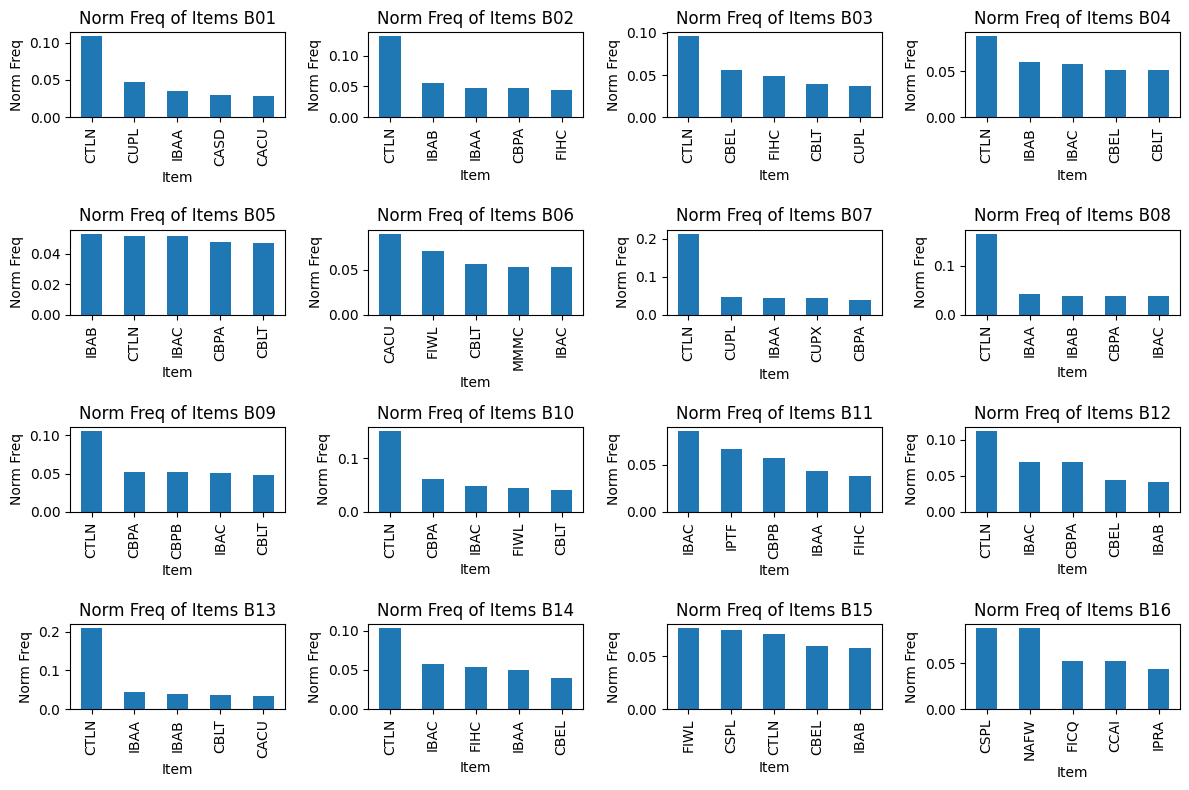

In [17]:
# Sort unique segment values in ascending order
sorted_items = sorted(data['beh_segment'].unique())

# Create a figure and axis objects for subplots
fig, axs = plt.subplots(4, 4, figsize=(12, 8))  # 2 rows, 2 columns

# Iterate over sorted segments and corresponding subplot axes
for item, ax in zip(sorted_items, axs.flatten()):
    # Filter the data to include only rows where 'segment' is equal to the current segment and remove any NONE items
    item_seg_data = data[(data['beh_segment'] == item)& (data['item'] != 'NONE')]
    
    # Calculate the frequency of each 'item_descrip' for the segment
    item_counts = item_seg_data['item'].value_counts()
    
    # Get the top 10 'item_descrip' based on the total frequency
    top_10_item_beh = item_counts.nlargest(5).index
    
    # Filter the item_descrip_counts series to include only the top 10 'item_descrip'
    top_10_item_counts = item_counts.loc[top_10_item_beh]
    
    # Calculate the total count of all 'item_descrip' entries for the segment
    total_item_count = item_seg_data['item'].count()
    
    # Normalize the frequency of each 'item_descrip' by the total number of all 'item_descrip' entries for the segment
    normalized_top_10_item_counts = top_10_item_counts.div(total_item_count)
    
    # Plot the normalized frequency of 'item_descrip' for the top 10 'item_descrip' for the current segment
    normalized_top_10_item_counts.plot(kind='bar', ax=ax)
    ax.set_xlabel('Item')
    ax.set_ylabel('Norm Freq')
    ax.set_title(f'Norm Freq of Items {item}')

plt.tight_layout()
plt.show()

In [115]:
data = pd.read_csv("./fnb_datav2.csv")

# Remove 
data = data.drop(columns = ["item_descrip"])
# Calculate the normalized frequency of occurrences for each item within each behavior segment
normalized_freq_per_item_per_segment = {}
sorted_beh_segs = sorted(data['beh_segment'].unique())
for seg in sorted_segs:

    item_seg_data = data[(data['beh_segment'] == seg)& (data['item'] != 'NONE')]
    #display(item_seg_data['item'].unique)
        # Calculate the frequency of each 'item_descrip' for the segment
    item_counts = item_seg_data['item'].value_counts()
        # Calculate the total count of all 'item_descrip' entries for the segment
    total_item_count = item_seg_data['item'].count()
        # Normalize the frequency of each 'item_descrip' by the total number of all 'item_descrip' entries for the segment
    normalized_item_counts = item_counts.div(total_item_count)
    # Store the normalized frequencies for each item within the segment
    
    for item, frequency in normalized_item_counts.items():
        if item not in normalized_freq_per_item_per_segment:
            normalized_freq_per_item_per_segment[item] = {'segment': seg, 'frequency': frequency}
        elif frequency > normalized_freq_per_item_per_segment[item]['frequency']:
            normalized_freq_per_item_per_segment[item] = {'segment': seg, 'frequency': frequency}

# Create a new feature column to store the name of the behavior segment with the highest normalized frequency for each item
data['beh_seg_max'] = data['item'].map(lambda x: normalized_freq_per_item_per_segment.get(x, {'segment': None})['segment'])

display(data[data['item'] != 'NONE'].head(30))

,idcol,interaction,int_date,item,page,tod,item_type,segment,beh_segment,active_ind,beh_seg_max
4,4521,CLICK,05FEB2023,IBAB,Screen1,Afternoon,INSURE,segment1,B07,Semi Active,None
5,4521,CHECKOUT,05FEB2023,IBAB,Screen1,Afternoon,INSURE,segment1,B07,Semi Active,None
16,14454,CLICK,08FEB2023,CAFM,Screen2,Morning,TRANSACT,segment2,B01,Active,None
17,14454,CHECKOUT,08FEB2023,CAFM,Screen2,Morning,TRANSACT,segment2,B01,Active,None
18,15000,CLICK,31JAN2023,CARF,Screen2,Morning,LEND,segment3,B01,Cold Start,None
19,15000,CHECKOUT,31JAN2023,CARF,Screen2,Morning,LEND,segment3,B01,Cold Start,None
26,22924,CLICK,26FEB2023,FIWL,Screen1,Morning,INVEST,segment2,B01,Active,None
27,22924,CHECKOUT,26FEB2023,FIWL,Screen1,Morning,INVEST,segment2,B01,Active,None
37,23484,CHECKOUT,22FEB2023,CUSS,Screen1,Afternoon,INVEST,segment2,B01,Cold Start,None
38,23484,CLICK,22FEB2023,CUSS,Screen1,Afternoon,INVEST,segment2,B01,Cold Start,None


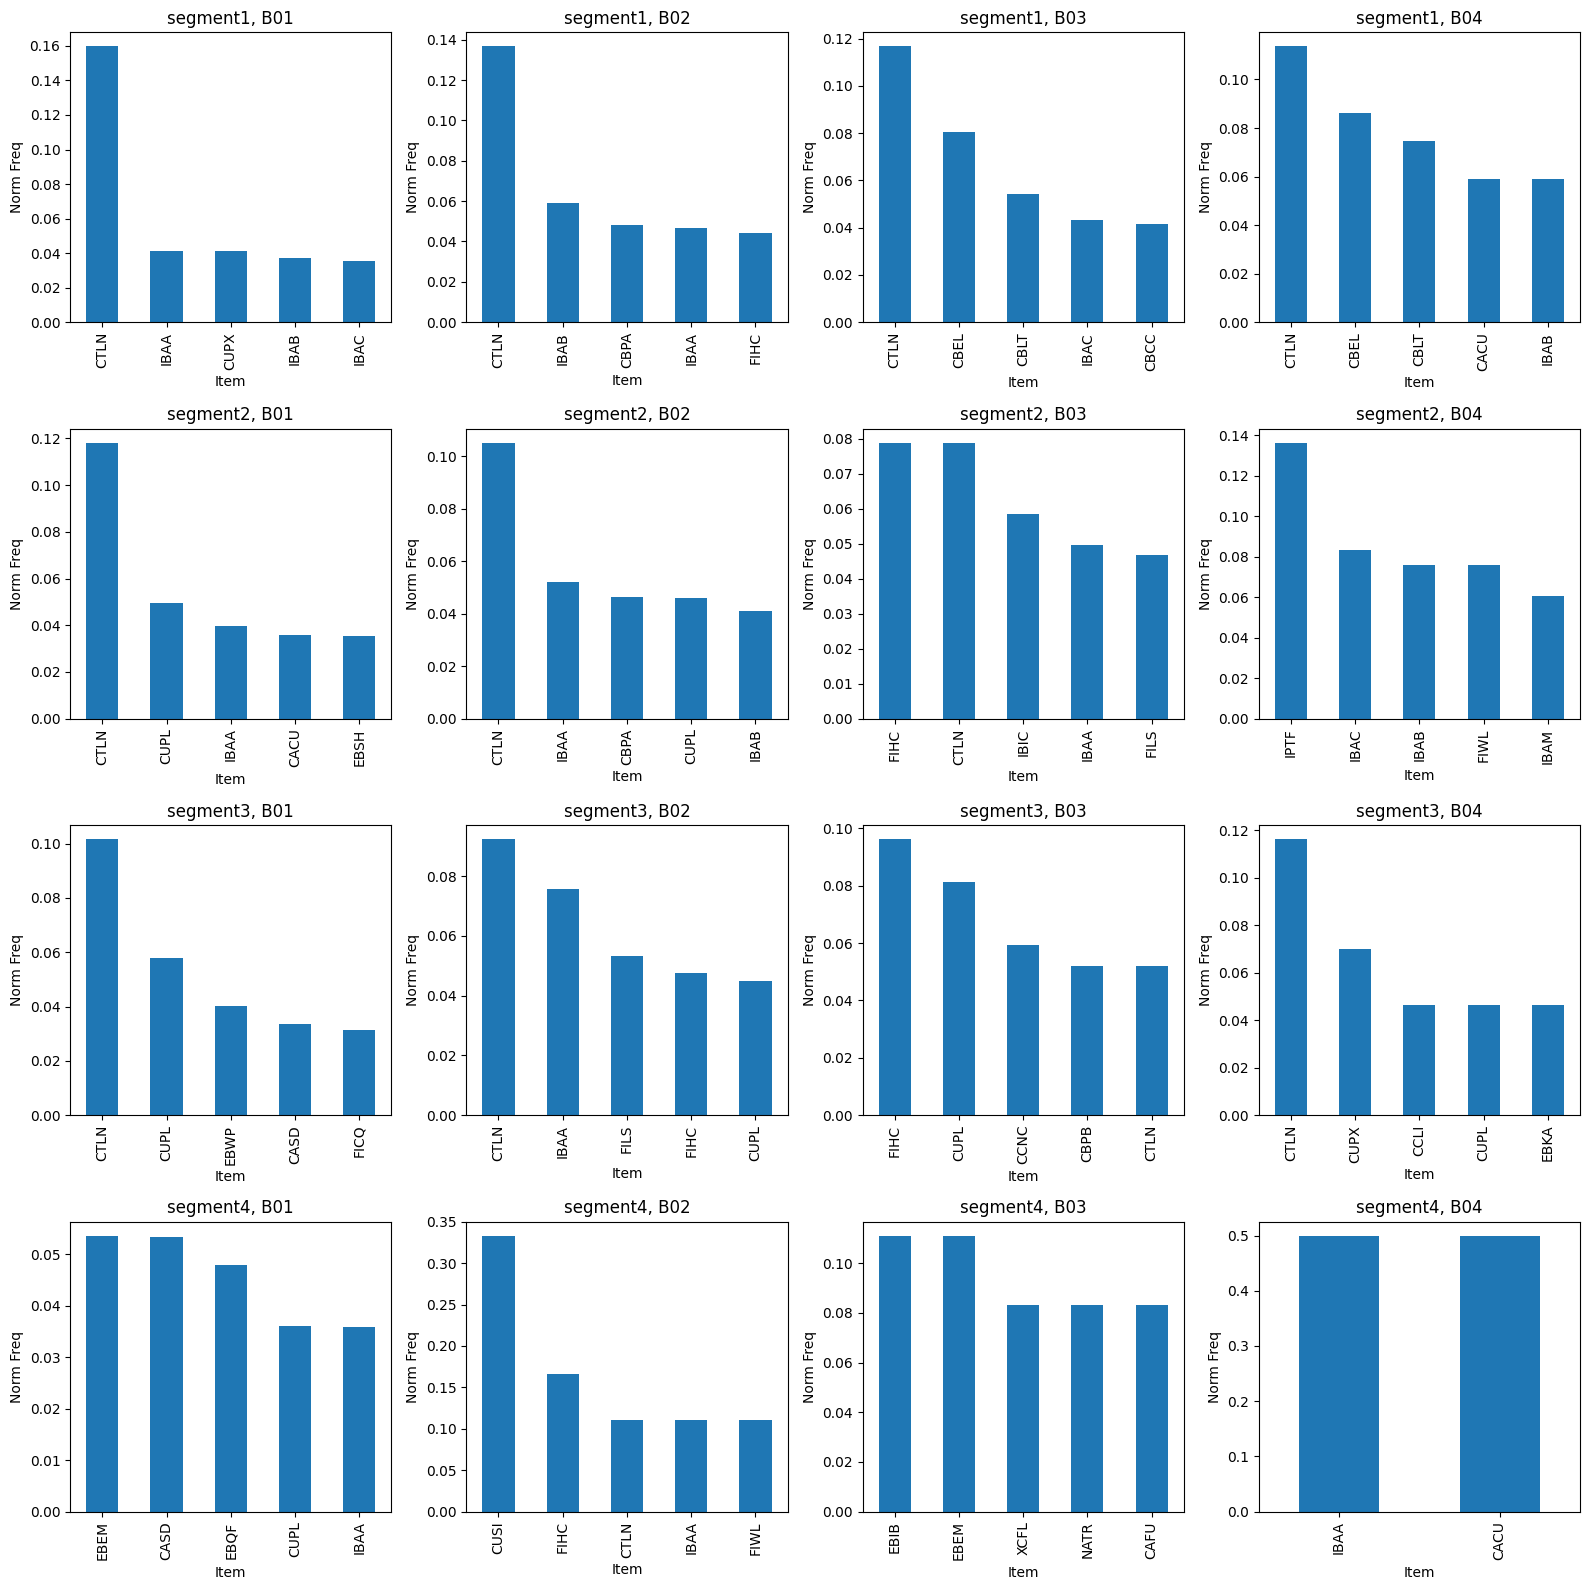

In [21]:

# Sort unique segment values in ascending order
sorted_segments = sorted(data['segment'].unique())
# Sort unique beh_segment values in ascending order
sorted_items = sorted(data['beh_segment'].unique())[:4]  # Select first 4 beh_segment categories

# Create a figure and axis objects for subplots
fig, axs = plt.subplots(len(sorted_segments), len(sorted_items), figsize=(16, 16))

# Iterate over sorted segments and corresponding subplot axes
for i, segment in enumerate(sorted_segments):
    for j, item in enumerate(sorted_items):
        # Filter the data to include only rows where 'segment' and 'beh_segment' are equal to the current segment and beh_segment
        segment_beh_segment_data = data[(data['segment'] == segment) & (data['beh_segment'] == item) & (data['item'] != 'NONE')]
        
        # Calculate the frequency of each 'item' for the segment and beh_segment combination
        item_counts = segment_beh_segment_data['item'].value_counts()
        
        # Get the top 5 'item' based on the total frequency
        top_5_items = item_counts.nlargest(5).index
        
        # Filter the item_counts series to include only the top 5 'item'
        top_5_item_counts = item_counts.loc[top_5_items]
        
        # Calculate the total count of all 'item' entries for the segment and beh_segment combination
        total_item_count = segment_beh_segment_data['item'].count()
        
        # Normalize the frequency of each 'item' by the total number of all 'item' entries for the segment and beh_segment combination
        normalized_top_5_item_counts = top_5_item_counts.div(total_item_count)
        
        # Plot the normalized frequency of 'item' for the top 5 'item' for the current segment and beh_segment combination
        normalized_top_5_item_counts.plot(kind='bar', ax=axs[i, j])
        axs[i, j].set_xlabel('Item')
        axs[i, j].set_ylabel('Norm Freq')
        axs[i, j].set_title(f'{segment}, {item}')

plt.tight_layout()
plt.show()

### time of day that a feature is accessed most
NONEs excluded

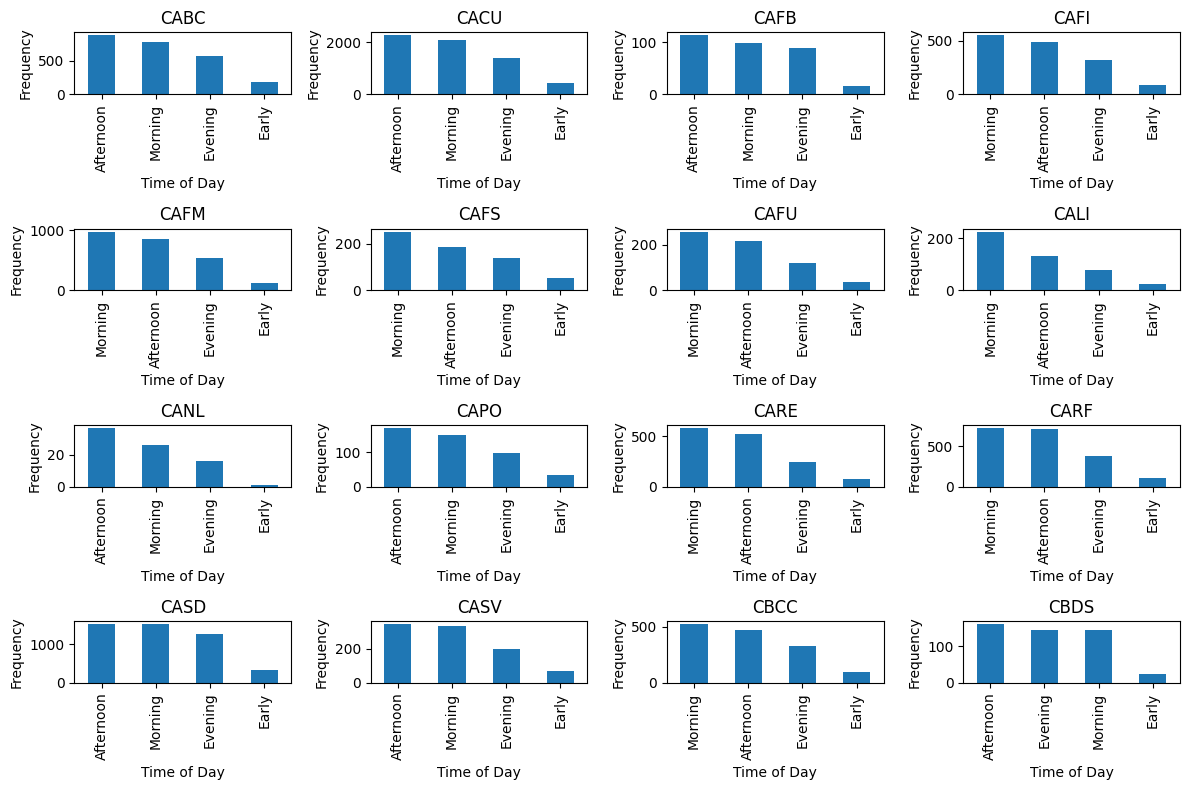

In [29]:
# Sort unique item values in ascending order
sorted_items = sorted(data['item'].unique())

# Create a figure and axis objects for subplots
fig, axs = plt.subplots(4, 4, figsize=(12, 8))  # 4 rows, 4 columns

# Iterate over sorted items and corresponding subplot axes
for item, ax in zip(sorted_items, axs.flatten()):
    # Filter the data to include only rows where 'item' is equal to the current item and remove any NONE items
    item_seg_data = data[(data['item'] == item) & (data['item'] != 'NONE')]
    
    # Calculate the frequency of interactions for each value of the 'tod' column
    tod_counts = item_seg_data['tod'].value_counts()
    
    # Get the top 5 'tod' values based on the total frequency
    top_5_tod = tod_counts.nlargest(5).index
    
    # Filter the tod_counts series to include only the top 5 'tod' values
    top_5_tod_counts = tod_counts.loc[top_5_tod]
    
    # Plot the frequency of interactions for the top 5 'tod' values for the current item
    top_5_tod_counts.plot(kind='bar', ax=ax)
    ax.set_xlabel('Time of Day')
    ax.set_ylabel('Frequency')
    ax.set_title(f'{item}')

plt.tight_layout()
plt.show()

### day of week item is accessed most

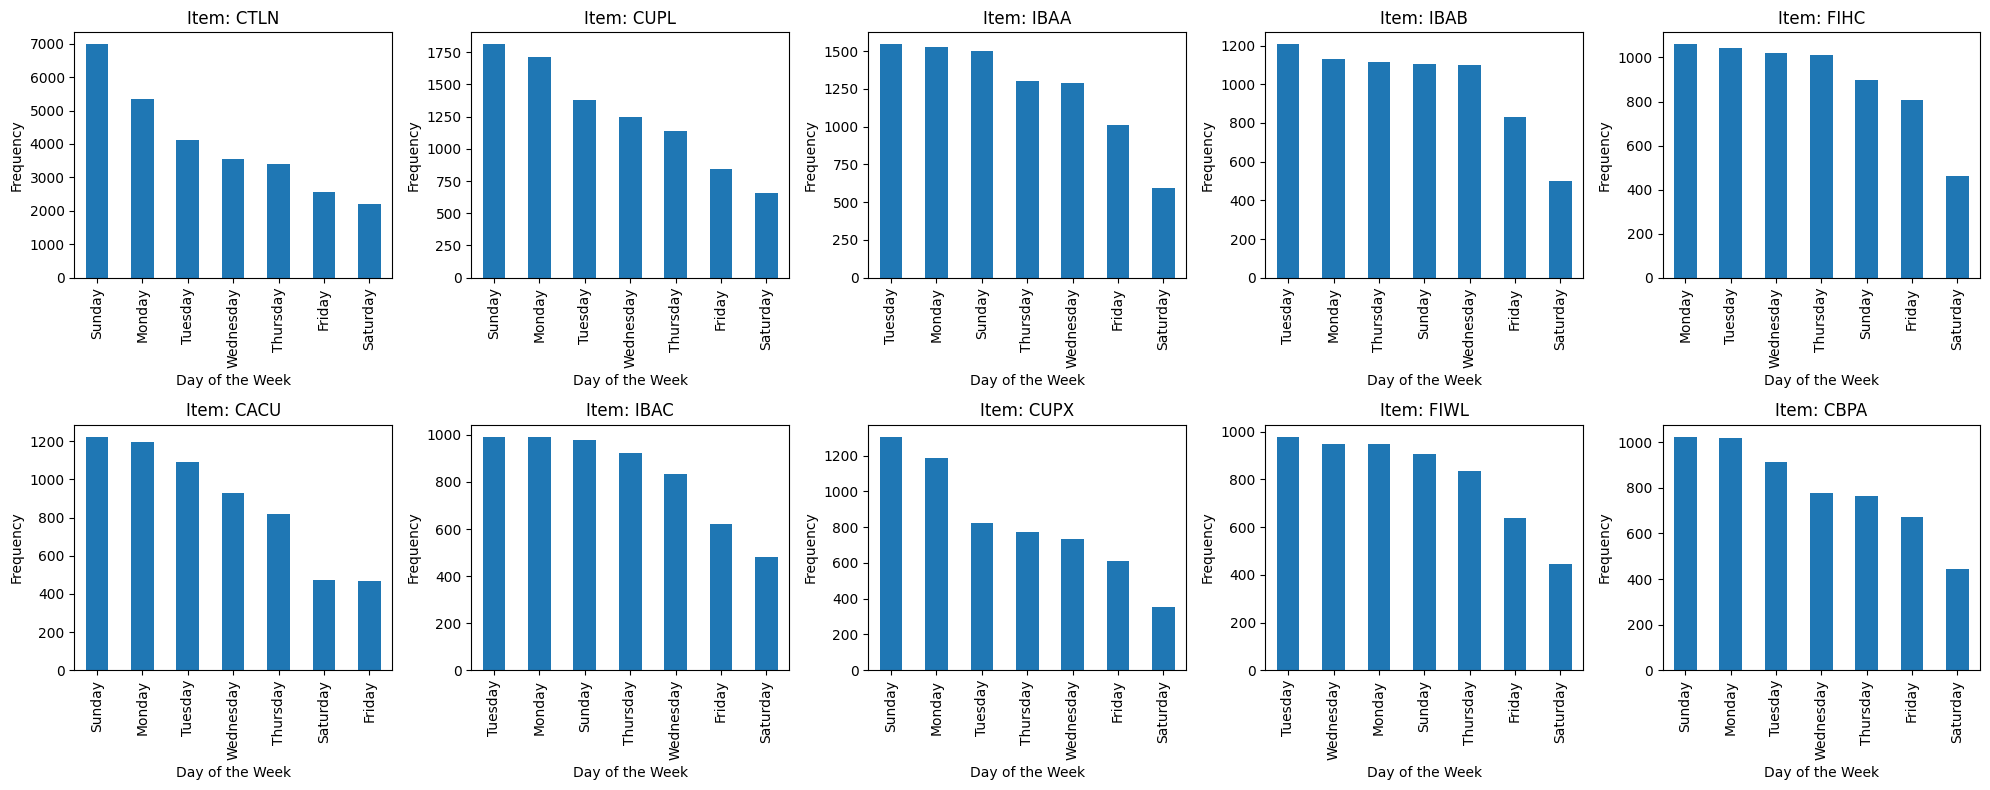

In [40]:

# Ensure 'int_date' is in datetime format
data['int_date'] = pd.to_datetime(data['int_date'], format='%d%b%Y')

# Create a new column for the day of the week
data['day_of_week'] = data['int_date'].dt.day_name()

# Exclude data where the item is 'NONE'
filtered_data = data[data['item'] != 'NONE']

# Calculate the total number of interactions for each item
item_interaction_counts = filtered_data['item'].value_counts()

# Get the top 10 items based on the total number of interactions
top_10_items = item_interaction_counts.index[:10]

# Create a figure and axis objects for subplots
fig, axs = plt.subplots(2, 5, figsize=(20, 8))  # 2 rows, 5 columns

# Iterate over the top 10 items and corresponding subplot axes
for item, ax in zip(top_10_items, axs.flatten()):
    # Filter the data to include only rows where 'item' is equal to the current item
    item_data = filtered_data[filtered_data['item'] == item]
    
    # Calculate the frequency of interactions for each day of the week
    day_of_week_counts = item_data['day_of_week'].value_counts()
    
    # Plot the frequency of interactions for each day of the week for the current item
    day_of_week_counts.plot(kind='bar', ax=ax)
    ax.set_xlabel('Day of the Week')
    ax.set_ylabel('Frequency')
    ax.set_title(f'Item: {item}')

plt.tight_layout()
plt.show()

## User features


### Activity score

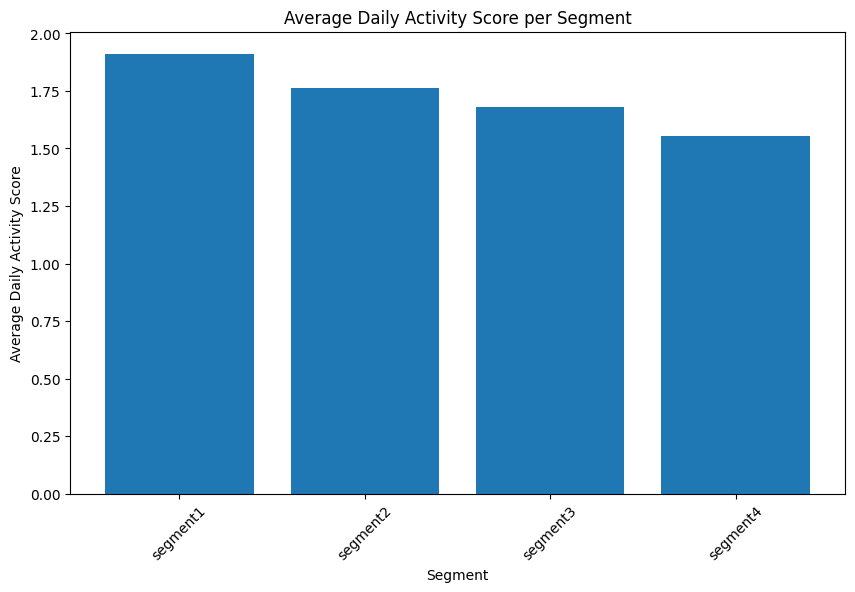

In [66]:
# Add user daily activity score:
# On days that they are active, how many interactions do they make?
# Convert int_date to datetime
data['int_date'] = pd.to_datetime(data['int_date'], format='%d%b%Y')

# Group by idcol to calculate total interactions and unique active days
user_interactions = data.groupby('idcol').size().reset_index(name='total_interactions')
active_days = data.groupby('idcol')['int_date'].nunique().reset_index(name='unique_active_days')

# Merge the results to calculate daily_activity_score
user_activity = pd.merge(user_interactions, active_days, on='idcol')
user_activity['daily_activity_score'] = user_activity['total_interactions'] / user_activity['unique_active_days']

# Merge the daily_activity_score back to the original DataFrame
data2 = pd.merge(data, user_activity[['idcol', 'daily_activity_score']], on='idcol', how='left')

data2.head(10)

# Calculate the mean daily activity score per segment
segment_activity_rate = data2.groupby('segment')['daily_activity_score'].mean().reset_index()

# Plot the activity score per segment
plt.figure(figsize=(10, 6))
plt.bar(segment_activity_rate['segment'], segment_activity_rate['daily_activity_score'])
plt.xlabel('Segment')
plt.ylabel('Average Daily Activity Score')
plt.title('Average Daily Activity Score per Segment')
plt.xticks(rotation=45)
plt.show()

### Activity frequency/rate

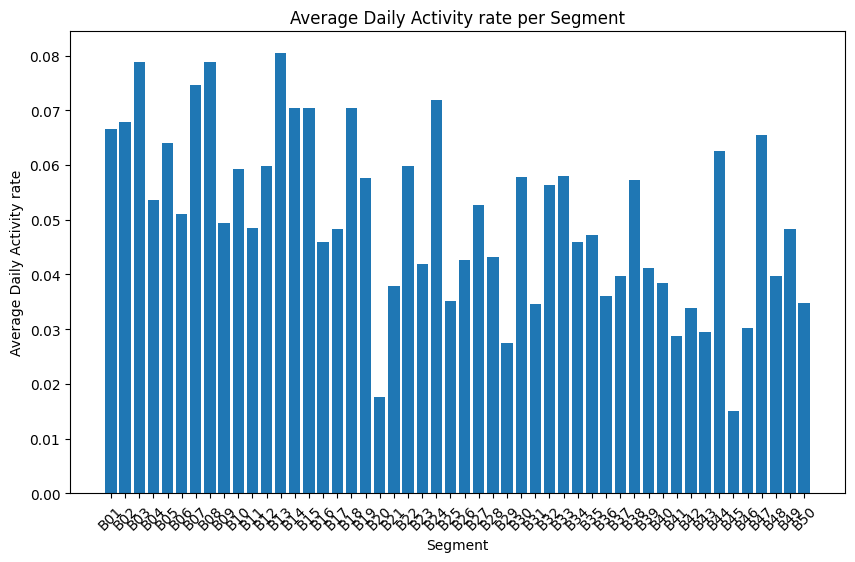

In [81]:
# Convert int_date to datetime
data['int_date'] = pd.to_datetime(data['int_date'])

# Calculate the total number of unique days in the dataset
total_days = data["int_date"].nunique()

# Calculate the number of unique days each user had interactions
user_unique_days = data.groupby('idcol')['int_date'].nunique()

# Calculate the activity rate
activity_rate = user_unique_days / total_days

# Merge the activity_rate back into the original dataframe
data3 = data.merge(activity_rate.rename('activity_rate'), on='idcol')

data3.head(20)
# Calculate the mean daily activity score per segment
segment_activity_rate = data3.groupby('beh_segment')['activity_rate'].mean().reset_index()

# Plot the activity score per segment
plt.figure(figsize=(10, 6))
plt.bar(segment_activity_rate['beh_segment'], segment_activity_rate['activity_rate'])
plt.xlabel('Segment')
plt.ylabel('Average Daily Activity rate')
plt.title('Average Daily Activity rate per Segment')
plt.xticks(rotation=45)
plt.show()

### TOD users interact most

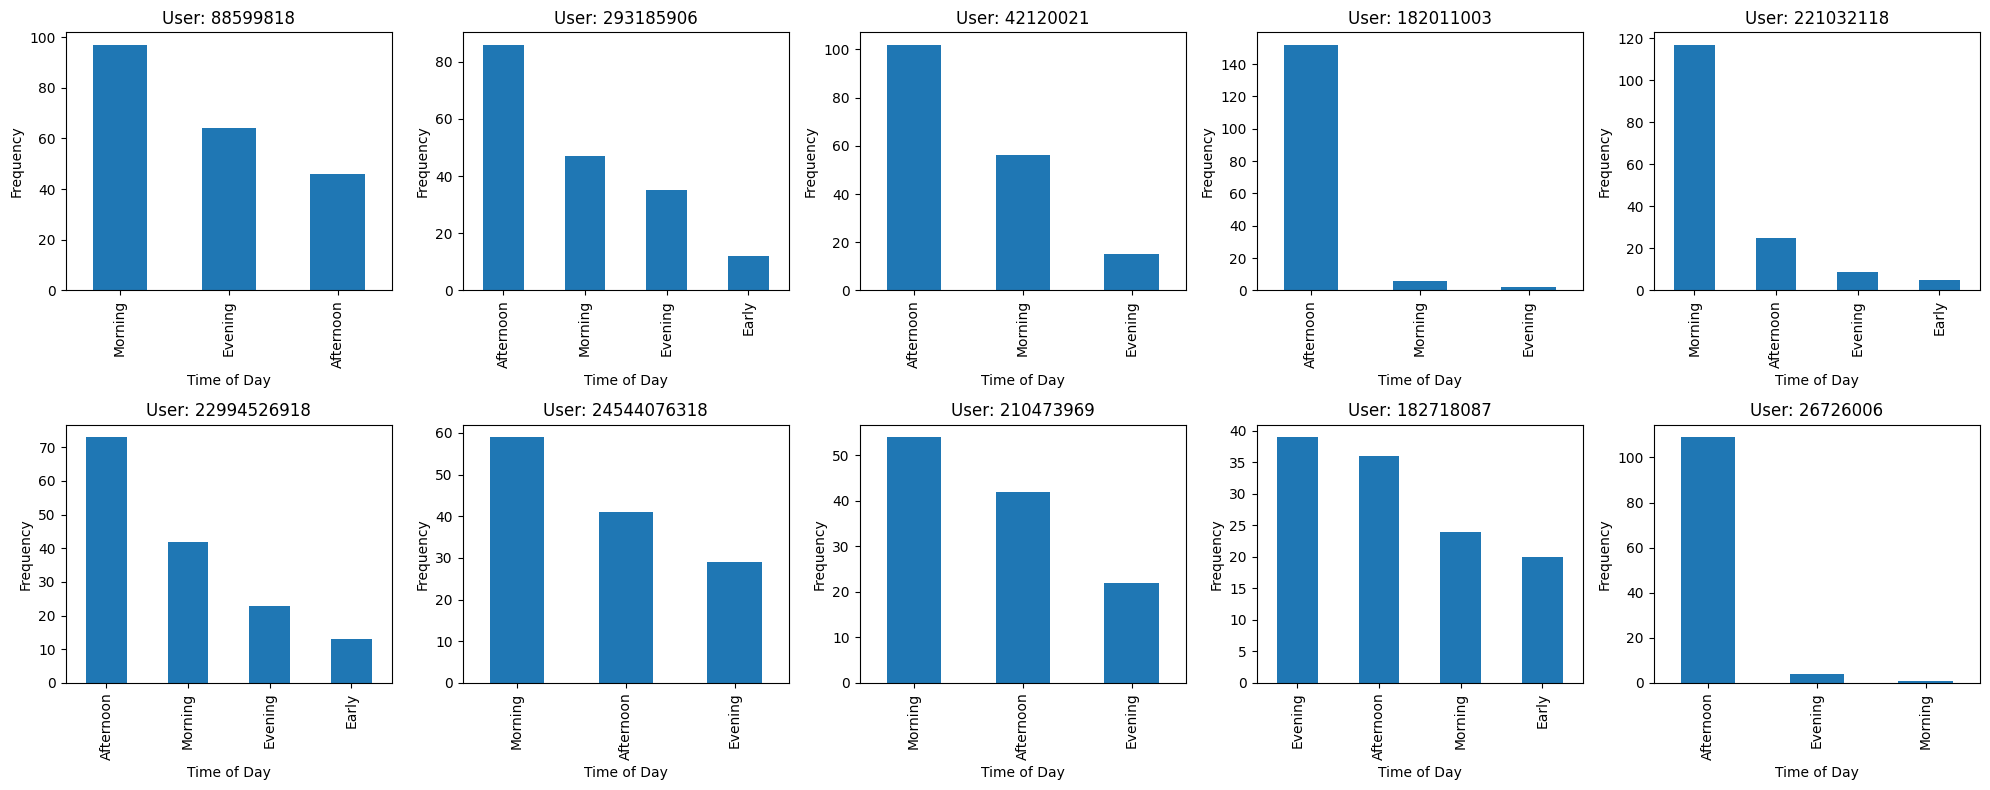

In [36]:
# Exclude data where the item is 'NONE'
filtered_data = data[data['item'] != 'NONE']

# Calculate the total number of interactions for each user
user_interaction_counts = filtered_data['idcol'].value_counts()

# Get the top 5 users based on the total number of interactions
users = user_interaction_counts.index[:10]#user_interaction_counts.nlargest(5).index

# Create a figure and axis objects for subplots
fig, axs = plt.subplots(2, 5, figsize=(20, 8))  # 1 row, 5 columns

# Iterate over the top 5 users and corresponding subplot axes
for user, ax in zip(users, axs.flatten()):
    # Filter the data to include only rows where 'idcol' is equal to the current user
    user_tod_data = data[data['idcol'] == user]
    
    # Calculate the frequency of interactions for each value of the 'tod' column
    tod_counts = user_tod_data['tod'].value_counts()
    
    # Plot the frequency of interactions for each 'tod' value for the current user
    tod_counts.plot(kind='bar', ax=ax)
    ax.set_xlabel('Time of Day')
    ax.set_ylabel('Frequency')
    ax.set_title(f'User: {user}')

plt.tight_layout()
plt.show()

### day of the week that users interact on

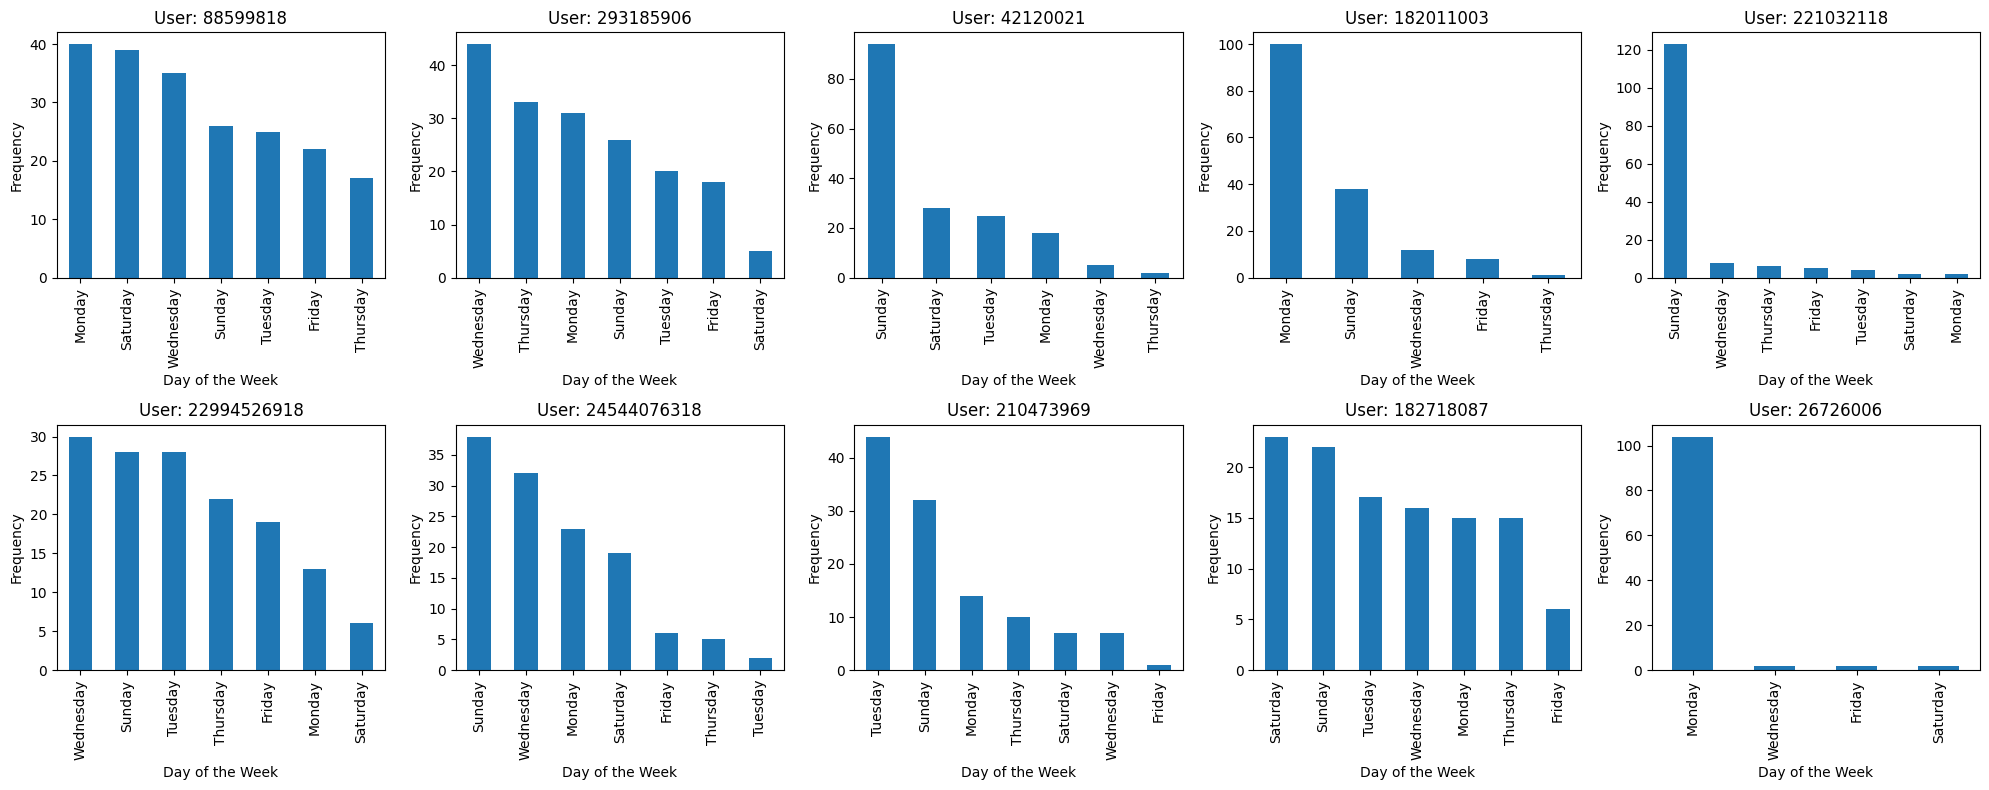

In [38]:
# Ensure 'int_date' is in datetime format
data['int_date'] = pd.to_datetime(data['int_date'], format='%d%b%Y')

# Create a new column for the day of the week
data['day_of_week'] = data['int_date'].dt.day_name()

# Exclude data where the item is 'NONE'
filtered_data = data[data['item'] != 'NONE']

# Calculate the total number of interactions for each user
user_interaction_counts = filtered_data['idcol'].value_counts()

# Get the top 10 users based on the total number of interactions
top_10_users = user_interaction_counts.index[:10]

# Create a figure and axis objects for subplots
fig, axs = plt.subplots(2, 5, figsize=(20, 8))  # 2 rows, 5 columns

# Iterate over the top 10 users and corresponding subplot axes
for user, ax in zip(top_10_users, axs.flatten()):
    # Filter the data to include only rows where 'idcol' is equal to the current user
    user_data = filtered_data[filtered_data['idcol'] == user]
    
    # Calculate the frequency of interactions for each day of the week
    day_of_week_counts = user_data['day_of_week'].value_counts()
    
    # Plot the frequency of interactions for each day of the week for the current user
    day_of_week_counts.plot(kind='bar', ax=ax)
    ax.set_xlabel('Day of the Week')
    ax.set_ylabel('Frequency')
    ax.set_title(f'User: {user}')

plt.tight_layout()
plt.show()

In [5]:
# Load the data
data = pd.read_csv("./fnb_datav2.csv")

# Assuming 'int_date' is in a format that can be converted to datetime
data['int_date'] = pd.to_datetime(data['int_date'], format='%d%b%Y')

# Temporal Features
data['interaction_weekday'] = data['int_date'].dt.dayofweek
data['interaction_month'] = data['int_date'].dt.month
data['interaction_year'] = data['int_date'].dt.year

# Frequency Features
interaction_counts = data.groupby('idcol').size().reset_index(name='interaction_count')
unique_items_interacted = data.groupby('idcol')['item'].nunique().reset_index(name='unique_items_interacted')
unique_pages_visited = data.groupby('idcol')['page'].nunique().reset_index(name='unique_pages_visited')

# Behavioral Features
interaction_type_count = data.groupby(['idcol', 'interaction']).size().unstack(fill_value=0).reset_index()
is_checkout = data.groupby('idcol')['interaction'].apply(lambda x: int('CHECKOUT' in x.values)).reset_index(name='is_checkout')

# Segmentation Features
segment_interaction_count = data.groupby('segment').size().reset_index(name='segment_interaction_count')
unique_beh_segments = data.groupby('idcol')['beh_segment'].nunique().reset_index(name='unique_beh_segments')
active_ind_count = data.groupby(['idcol', 'active_ind']).size().unstack(fill_value=0).reset_index()

# Aggregated Features
first_last_interaction = data.groupby('idcol')['int_date'].agg(['min', 'max']).reset_index()
first_last_interaction['interaction_time_span'] = (first_last_interaction['max'] - first_last_interaction['min']).dt.days

# Merge all features into a single DataFrame
features = pd.merge(interaction_counts, unique_items_interacted, on='idcol')
features = pd.merge(features, unique_pages_visited, on='idcol')
features = pd.merge(features, interaction_type_count, on='idcol')
features = pd.merge(features, is_checkout, on='idcol')
features = pd.merge(features, unique_beh_segments, on='idcol')
features = pd.merge(features, active_ind_count, on='idcol')
features = pd.merge(features, first_last_interaction[['idcol', 'interaction_time_span']], on='idcol')

# Display the features DataFrame
print(features)

             idcol  interaction_count  unique_items_interacted  \
0              755                  1                        1   
1             4521                  5                        2   
2             6145                  4                        1   
3             7125                  1                        1   
4             8469                  3                        1   
...            ...                ...                      ...   
84370  25685663618                  3                        2   
84371  25693117918                  5                        2   
84372  25705258018                  7                        4   
84373  25721743718                  1                        1   
84374  25728632418                 18                        6   

       unique_pages_visited  CHECKOUT  CLICK  DISPLAY  is_checkout  \
0                         1         0      0        1            0   
1                         1         1      1        3            1 

In [3]:
# I remve a random Active user to test the cold start approach later:
# Step 1: Filter users with active_ind equal to 'Active'
active_users = data[data['active_ind'] == 'Active']

# Check if there are any active users
if not active_users.empty:
    # Step 2: Randomly select one of these users
    selected_user = active_users.sample(n=1)

    # Get the user id of the selected user
    selected_user_id = selected_user['idcol'].values[0]

    # Step 3: Move all entries of this selected user to a new dataframe
    selected_user_df = data[data['idcol'] == selected_user_id]

    # Step 4: Remove this user's entries from the original dataframe
    data = data[data['idcol'] != selected_user_id]

selected_user_df.head(-1)

,idcol,interaction,int_date,item,page,item_type,segment,beh_segment,active_ind
349740,22545191318,DISPLAY,26MAR2023,NONE,Screen1,ALL,segment1,B01,Active
349741,22545191318,DISPLAY,19MAR2023,NONE,Screen1,ALL,segment1,B01,Active
349742,22545191318,DISPLAY,11FEB2023,NONE,Screen1,ALL,segment1,B01,Active
349743,22545191318,DISPLAY,23MAR2023,NONE,Screen1,ALL,segment1,B01,Active
349744,22545191318,CLICK,10FEB2023,FIHC,Screen1,INSURE,segment1,B01,Active
349745,22545191318,CLICK,23FEB2023,FIHC,Screen1,INSURE,segment1,B01,Active
349746,22545191318,CLICK,30MAR2023,FIHC,Screen1,INSURE,segment1,B01,Active
349747,22545191318,CHECKOUT,09FEB2023,IBGC,Screen1,INSURE,segment1,B01,Active
349748,22545191318,CLICK,09FEB2023,IBGC,Screen1,INSURE,segment1,B01,Active
349749,22545191318,CLICK,05FEB2023,IBDP,Screen1,INSURE,segment1,B01,Active


In [4]:
# Checking transactions for a specific ID:
id = 77196041
data[data["idcol"]==id]

,idcol,interaction,int_date,item,page,item_type,segment,beh_segment,active_ind
155291,77196041,DISPLAY,26FEB2023,NONE,Screen1,ALL,segment2,B01,Active
155292,77196041,DISPLAY,16FEB2023,NONE,Screen1,ALL,segment2,B01,Active
155293,77196041,DISPLAY,29MAR2023,NONE,Screen1,ALL,segment2,B01,Active
155294,77196041,DISPLAY,05JAN2023,NONE,Screen1,ALL,segment2,B01,Active
155295,77196041,CLICK,27MAR2023,FICQ,Screen2,INSURE,segment2,B01,Active
...,...,...,...,...,...,...,...,...,...
155353,77196041,CLICK,27MAR2023,CACU,Screen2,TRANSACT,segment2,B01,Active
155354,77196041,CHECKOUT,27MAR2023,CABC,Screen2,INVEST,segment2,B01,Active
155355,77196041,CLICK,27MAR2023,CABC,Screen2,INVEST,segment2,B01,Active
155356,77196041,CHECKOUT,27MAR2023,SEVP,Screen2,TRANSACT,segment2,B01,Active


In [5]:
data.nunique()

idcol          84374
interaction        3
int_date          88
item             104
page               2
item_type          7
segment            4
beh_segment       50
active_ind         3
dtype: int64

In [6]:
# Add the following user features
"""
- weekly interaction frequency, 
- most frequenctly item interacted with (other than ALL),

"""

# Give scores to the interactions, and then drop the interaction column:L
interaction_scores = {
    'CLICK': 1,
    'CHECKOUT': 2
}

interaction_scores = {
    'DISPLAY': 0,
    'CLICK': 1,
    'CHECKOUT': 2
}

data['interaction_scores'] = data['interaction'].map(interaction_scores).fillna(0).astype(int)

# Add ids for each unique item
data['item_id'] = pd.factorize(data['item'])[0]

data.drop(columns = ["interaction"])
data.head()

,idcol,interaction,int_date,item,page,item_type,segment,beh_segment,active_ind,interaction_scores,item_id
0,755,DISPLAY,17JAN2023,NONE,Screen1,ALL,segment3,B01,Semi Active,0,0
1,4521,DISPLAY,27FEB2023,NONE,Screen1,ALL,segment1,B07,Semi Active,0,0
2,4521,DISPLAY,18FEB2023,NONE,Screen1,ALL,segment1,B07,Semi Active,0,0
3,4521,DISPLAY,30JAN2023,NONE,Screen1,ALL,segment1,B07,Semi Active,0,0
4,4521,CLICK,05FEB2023,IBAB,Screen1,INSURE,segment1,B07,Semi Active,1,1


# Add User Features:

#### Add the following user features
- weekly interaction frequency - on average, over the whole dataset, how many times does the user interact per week
- daily interaction frequency - similar to above
- monthly interaction frequency - how many times 
- most frequenctly item interacted with (other than ALL) over the whole 
- most frequently interacted with item type
- Ratio of checkout to click for each user-item combination (ask Lize)
- Add an activity score, which is a metric that says how often, over the entire dataset, is the user active
    - Done by dividing the number of unique active days by the number of days in the dataset
- Potential other features to add from TOD:
    - average time between clicking item
    - average time between checking out the item


In [55]:
original_data =  data.copy()

target_idcol = 77196041
index = int(original_data[original_data['idcol'] == target_idcol].index[0])


In [49]:
# Add user daily activity score:
# On days that they are active, how many interactions do they make?
# Convert int_date to datetime
data['int_date'] = pd.to_datetime(data['int_date'], format='%d%b%Y')

# Group by idcol to calculate total interactions and unique active days
user_interactions = data.groupby('idcol').size().reset_index(name='total_interactions')
active_days = data.groupby('idcol')['int_date'].nunique().reset_index(name='unique_active_days')

# Merge the results to calculate daily_activity_score
user_activity = pd.merge(user_interactions, active_days, on='idcol')
user_activity['daily_activity_score'] = user_activity['total_interactions'] / user_activity['unique_active_days']

# Merge the daily_activity_score back to the original DataFrame
data = pd.merge(data, user_activity[['idcol', 'daily_activity_score']], on='idcol', how='left')

data.head(10)

,idcol,interaction,int_date,item,page,tod,item_type,segment,beh_segment,active_ind,daily_activity_score
0,755,DISPLAY,2023-01-17,NONE,Screen1,Afternoon,ALL,segment3,B01,Semi Active,1.00
1,4521,DISPLAY,2023-02-27,NONE,Screen1,Afternoon,ALL,segment1,B07,Semi Active,1.25
2,4521,DISPLAY,2023-02-18,NONE,Screen1,Afternoon,ALL,segment1,B07,Semi Active,1.25
3,4521,DISPLAY,2023-01-30,NONE,Screen1,Morning,ALL,segment1,B07,Semi Active,1.25
4,4521,CLICK,2023-02-05,IBAB,Screen1,Afternoon,INSURE,segment1,B07,Semi Active,1.25
5,4521,CHECKOUT,2023-02-05,IBAB,Screen1,Afternoon,INSURE,segment1,B07,Semi Active,1.25
6,6145,DISPLAY,2023-02-26,NONE,Screen1,Evening,ALL,segment3,B01,Cold Start,1.00
7,6145,DISPLAY,2023-01-27,NONE,Screen1,Early,ALL,segment3,B01,Cold Start,1.00
8,6145,DISPLAY,2023-02-10,NONE,Screen1,Morning,ALL,segment3,B01,Cold Start,1.00
9,6145,DISPLAY,2023-01-10,NONE,Screen1,Afternoon,ALL,segment3,B01,Cold Start,1.00


In [9]:
# Add user activity frequency:
# Count the number of days that the user was active, and divide it by the number of days in the dataset:

# Convert int_date to datetime
data['int_date'] = pd.to_datetime(data['int_date'])

# Calculate the total number of unique days in the dataset
total_days = data["int_date"].nunique()

# Calculate the number of unique days each user had interactions
user_unique_days = data.groupby('idcol')['int_date'].nunique()

# Calculate the activity rate
activity_rate = user_unique_days / total_days

# Merge the activity_rate back into the original dataframe
data = data.merge(activity_rate.rename('activity_rate'), on='idcol')

data.head(20)

,idcol,interaction,int_date,item,page,item_type,segment,beh_segment,active_ind,interaction_scores,item_id,daily_activity_score,activity_rate
0,755,DISPLAY,2023-01-17,NONE,Screen1,ALL,segment3,B01,Semi Active,0,0,1.00,0.011364
1,4521,DISPLAY,2023-02-27,NONE,Screen1,ALL,segment1,B07,Semi Active,0,0,1.25,0.045455
2,4521,DISPLAY,2023-02-18,NONE,Screen1,ALL,segment1,B07,Semi Active,0,0,1.25,0.045455
3,4521,DISPLAY,2023-01-30,NONE,Screen1,ALL,segment1,B07,Semi Active,0,0,1.25,0.045455
4,4521,CLICK,2023-02-05,IBAB,Screen1,INSURE,segment1,B07,Semi Active,1,1,1.25,0.045455
5,4521,CHECKOUT,2023-02-05,IBAB,Screen1,INSURE,segment1,B07,Semi Active,2,1,1.25,0.045455
6,6145,DISPLAY,2023-02-26,NONE,Screen1,ALL,segment3,B01,Cold Start,0,0,1.00,0.045455
7,6145,DISPLAY,2023-01-27,NONE,Screen1,ALL,segment3,B01,Cold Start,0,0,1.00,0.045455
8,6145,DISPLAY,2023-02-10,NONE,Screen1,ALL,segment3,B01,Cold Start,0,0,1.00,0.045455
9,6145,DISPLAY,2023-01-10,NONE,Screen1,ALL,segment3,B01,Cold Start,0,0,1.00,0.045455


In [10]:
# # Adding daily, weekly and monthly interaction frequencies, over entire dataset
# # The interactions can be click, checkout or display. This is more a value for how often the user opens the app,
# # rather than how often they actually view or buy an item

# # Daily 

# data = original_data.copy()
# # Convert int_date to datetime
# data['int_date'] = pd.to_datetime(data['int_date'], format='%d%b%Y')

# # Calculate daily interaction frequency
# daily_freq = data.groupby(['idcol', 'int_date']).size().groupby(level=0).mean().reset_index(name='avg_daily_freq')

# # Calculate weekly interaction frequency
# data['week'] = data['int_date'].dt.isocalendar().week
# weekly_freq = data.groupby(['idcol', 'week']).size().groupby(level=0).mean().reset_index(name='avg_weekly_freq')

# # # Calculate monthly interaction frequency
# # data['month'] = data['int_date'].dt.to_period('M')
# # monthly_freq = data.groupby(['idcol', 'month']).size().groupby(level=0).mean().reset_index(name='avg_monthly_freq')

# # Merge frequencies back into the original DataFrame
# data = data.merge(daily_freq, on='idcol')
# data = data.merge(weekly_freq, on='idcol')
# data = data.merge(monthly_freq, on='idcol')

# data.head(20)

In [11]:
# # Add the activity score:
# # Convert 'int_date' to datetime format
# data['int_date'] = pd.to_datetime(data['int_date'], format='%d%b%Y')

# # Calculate the total number of unique days in the dataset
# total_unique_days = data['int_date'].nunique()

# data = data.sort_values(by='int_date', ascending=False)


# # # Calculate the number of unique days each user was active
# user_unique_days = df.groupby('idcol')['int_date'].nunique().reset_index(name='active_days')

# # Calculate the activity score for each user
# user_unique_days['activity_score'] = user_unique_days['active_days'] / total_unique_days

# # Merge the activity score back into the original dataframe
# df = df.merge(user_unique_days[['idcol', 'activity_score']], on='idcol')

# print("DataFrame with activity score:")
# print(df)

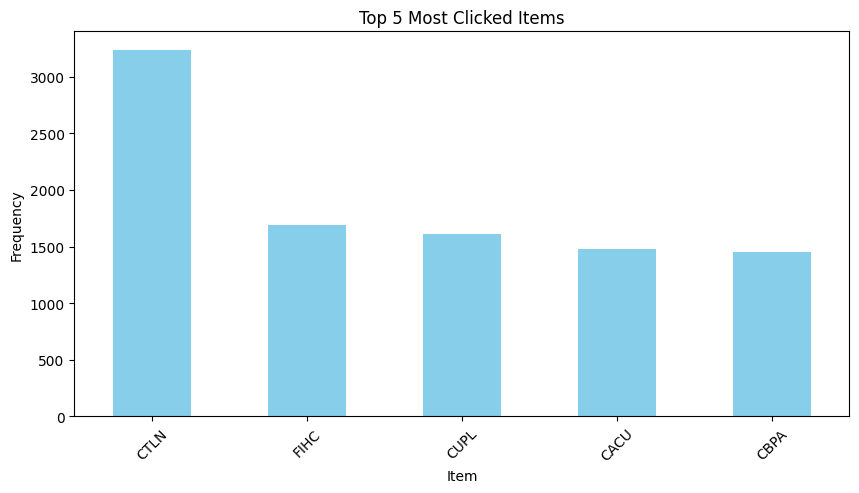

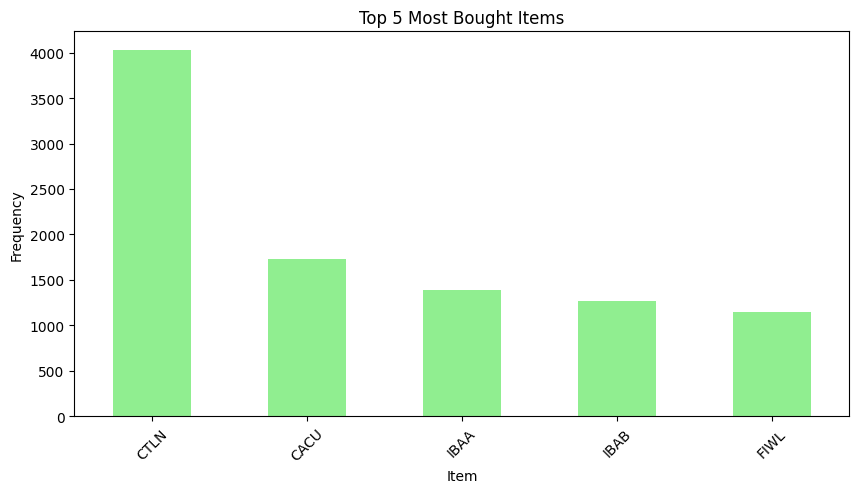

In [127]:
# Adding most clicked and most bought items and item types for each user:
clicks = data[data['interaction'] == 'CLICK']
most_clicked = clicks.groupby(['idcol', 'item']).size().reset_index(name='click_count')
most_clicked = most_clicked.loc[most_clicked.groupby('idcol')['click_count'].idxmax()][['idcol', 'item']]
most_clicked.rename(columns={'item': 'most_clicked_item'}, inplace=True)

# Determine the most bought item for each user
checkouts = data[data['interaction'] == 'CHECKOUT']
most_bought = checkouts.groupby(['idcol', 'item']).size().reset_index(name='checkout_count')
most_bought = most_bought.loc[most_bought.groupby('idcol')['checkout_count'].idxmax()][['idcol', 'item']]
most_bought.rename(columns={'item': 'most_bought_item'}, inplace=True)

# Merge the most clicked and most bought items back into the original DataFrame
# data = data.merge(most_clicked, on='idcol', how='left')
# data = data.merge(most_bought, on='idcol', how='left')
# Determine the top 5 most clicked and most bought items overall
top_5_clicked = most_clicked['most_clicked_item'].value_counts().nlargest(5)
top_5_bought = most_bought['most_bought_item'].value_counts().nlargest(5)
data.head()
# Plot the frequencies of the top 5 most clicked items
plt.figure(figsize=(10, 5))
top_5_clicked.plot(kind='bar', color='skyblue')
plt.title('Top 5 Most Clicked Items')
plt.xlabel('Item')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.show()

# Plot the frequencies of the top 5 most bought items
plt.figure(figsize=(10, 5))
top_5_bought.plot(kind='bar', color='lightgreen')
plt.title('Top 5 Most Bought Items')
plt.xlabel('Item')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.show()

In [13]:
# Adding most clicked and most bought items and item types for each user:
clicks = data[data['interaction'] == 'CLICK']
most_clicked = clicks.groupby(['idcol', 'item_type']).size().reset_index(name='click_count')
most_clicked = most_clicked.loc[most_clicked.groupby('idcol')['click_count'].idxmax()][['idcol', 'item_type']]
most_clicked.rename(columns={'item_type': 'most_clicked_item_type'}, inplace=True)

# Determine the most bought item for each user
checkouts = data[data['interaction'] == 'CHECKOUT']
most_bought = checkouts.groupby(['idcol', 'item_type']).size().reset_index(name='checkout_count')
most_bought = most_bought.loc[most_bought.groupby('idcol')['checkout_count'].idxmax()][['idcol', 'item_type']]
most_bought.rename(columns={'item_type': 'most_bought_item_type'}, inplace=True)

# Merge the most clicked and most bought items back into the original DataFrame
# data = data.merge(most_clicked, on='idcol', how='left')
# data = data.merge(most_bought, on='idcol', how='left')

# data.head()

,idcol,interaction,int_date,item,page,item_type,segment,beh_segment,active_ind,interaction_scores,item_id,daily_activity_score,activity_rate,most_clicked_item,most_bought_item,most_clicked_item_type,most_bought_item_type
0,755,DISPLAY,2023-01-17,NONE,Screen1,ALL,segment3,B01,Semi Active,0,0,1.00,0.011364,NaN,NaN,NaN,NaN
1,4521,DISPLAY,2023-02-27,NONE,Screen1,ALL,segment1,B07,Semi Active,0,0,1.25,0.045455,IBAB,IBAB,INSURE,INSURE
2,4521,DISPLAY,2023-02-18,NONE,Screen1,ALL,segment1,B07,Semi Active,0,0,1.25,0.045455,IBAB,IBAB,INSURE,INSURE
3,4521,DISPLAY,2023-01-30,NONE,Screen1,ALL,segment1,B07,Semi Active,0,0,1.25,0.045455,IBAB,IBAB,INSURE,INSURE
4,4521,CLICK,2023-02-05,IBAB,Screen1,INSURE,segment1,B07,Semi Active,1,1,1.25,0.045455,IBAB,IBAB,INSURE,INSURE


In [14]:
# # For each unique user/item combination, what is the ratio of CHECKOUT to CLICK?# First, filter the DataFrame to include only CHECKOUT and CLICK interactions
# # NOTE: This isn't valid because an item doesn't need to be clicked to check it out - that is weird. I can intelligently fill NaN values with 1 if there was a 
# # checkout but no click and 0 otherwise, but ask Lizes opinion first

# checkout_click_df = data[data['interaction'].isin(['CHECKOUT', 'CLICK'])]

# # Group by unique idcol-item combinations and count the occurrences of each interaction type
# interaction_counts = checkout_click_df.groupby(['idcol', 'item', 'interaction']).size().unstack(fill_value=0)

# # Calculate the ratio of CHECKOUT to CLICK interactions
# interaction_counts['checkout_click_ratio'] = interaction_counts['CHECKOUT'] / interaction_counts['CLICK']


# # # Merge the ratio back to the original DataFrame based on idcol and item
# # data = data.merge(interaction_counts.reset_index()[['idcol', 'item', 'checkout_click_ratio']], on=['idcol', 'item'], how='left')

# # # Display the DataFrame with the new column
# # data.head(20)

In [15]:
# # On which page did the user checkout on the item most frequently? (NOT USING)
# # Filter the DataFrame to include only CLICK interactions
# click_df = data[data['interaction'] == 'CHECKOUT']

# # Group by user-item-screen combination and count the occurrences
# click_counts = click_df.groupby(['idcol', 'item', 'page'])['interaction'].count().reset_index()

# # Find the screen with the maximum count for each user-item combination
# max_click_screen = click_counts.groupby(['idcol', 'item']).apply(lambda x: x.loc[x['interaction'].idxmax()]).reset_index(drop=True)

# # Merge the result back to the original DataFrame based on user-item combination
# data = data.merge(max_click_screen[['idcol', 'item', 'page']], on=['idcol', 'item'], how='left')
# data.rename(columns={'page': 'most_checked_out_screen'}, inplace=True)

# # Display the DataFrame with the new column
# data.head(20)

In [16]:
# I will fill NaN values with the mode of the data, for people of the same segment and BEH segment, for people that have not 
# clicked or bought any items

def fill_nan_with_mode_for_segment_and_beh_segment(data):
    # Get unique combinations of segment and beh_segment
    unique_combinations = data[['segment', 'beh_segment']].drop_duplicates()

    for index, row in unique_combinations.iterrows():
        segment = row['segment']
        beh_segment = row['beh_segment']
        
        # Filter the DataFrame based on the current segment and beh_segment
        filtered_data = data[(data['segment'] == segment) & (data['beh_segment'] == beh_segment)]
        
        # Calculate mode for each column within the segment and beh_segment group
        mode_values = filtered_data.mode().iloc[0]
        
        # Replace NaN values in the original DataFrame with mode values for the current segment and beh_segment
        data.loc[(data['segment'] == segment) & (data['beh_segment'] == beh_segment)] = \
            filtered_data.fillna(mode_values)
    
    return data


test = fill_nan_with_mode_for_segment_and_beh_segment(data)

test.head()

,idcol,interaction,int_date,item,page,item_type,segment,beh_segment,active_ind,interaction_scores,item_id,daily_activity_score,activity_rate,most_clicked_item,most_bought_item,most_clicked_item_type,most_bought_item_type
0,755,DISPLAY,2023-01-17,NONE,Screen1,ALL,segment3,B01,Semi Active,0,0,1.00,0.011364,CTLN,CTLN,LEND,LEND
1,4521,DISPLAY,2023-02-27,NONE,Screen1,ALL,segment1,B07,Semi Active,0,0,1.25,0.045455,IBAB,IBAB,INSURE,INSURE
2,4521,DISPLAY,2023-02-18,NONE,Screen1,ALL,segment1,B07,Semi Active,0,0,1.25,0.045455,IBAB,IBAB,INSURE,INSURE
3,4521,DISPLAY,2023-01-30,NONE,Screen1,ALL,segment1,B07,Semi Active,0,0,1.25,0.045455,IBAB,IBAB,INSURE,INSURE
4,4521,CLICK,2023-02-05,IBAB,Screen1,INSURE,segment1,B07,Semi Active,1,1,1.25,0.045455,IBAB,IBAB,INSURE,INSURE


### Add Item Features
- Most bought by segment
- Most bought by beh segment
- Most clicked by segment
- Most clicked by beh_segment
- For this item, what is the ratio of checkouts to clicks over the entire dataset?
- WHich screen was this item accessed from the most?

In [17]:
original_data = data.copy()

In [18]:
data = original_data.copy()
# data.head()

# Which segment clicked this item the most?
# Step 1: Filter to only include "CLICK" interactions
click_data = data[data['interaction'] == 'CLICK']
# Step 2: Group by item and segment, count the number of "CLICK" interactions
click_counts = click_data.groupby(['item', 'segment']).size().reset_index(name='click_count')

# Step 3: Determine the segment with the maximum "CLICK" interactions for each item
most_clicked_by_seg = click_counts.loc[click_counts.groupby('item')['click_count'].idxmax()]

# Step 4: Create a dictionary to map items to the segment with the most "CLICK" interactions
item_to_segment = most_clicked_by_seg.set_index('item')['segment'].to_dict()

# Step 5: Map this information back to the original dataframe
data['most_clicked_by_seg'] = data['item'].map(item_to_segment)

data.head(20)


,idcol,interaction,int_date,item,page,item_type,segment,beh_segment,active_ind,interaction_scores,item_id,daily_activity_score,activity_rate,most_clicked_item,most_bought_item,most_clicked_item_type,most_bought_item_type,most_clicked_by_seg
0,755,DISPLAY,2023-01-17,NONE,Screen1,ALL,segment3,B01,Semi Active,0,0,1.00,0.011364,CTLN,CTLN,LEND,LEND,NaN
1,4521,DISPLAY,2023-02-27,NONE,Screen1,ALL,segment1,B07,Semi Active,0,0,1.25,0.045455,IBAB,IBAB,INSURE,INSURE,NaN
2,4521,DISPLAY,2023-02-18,NONE,Screen1,ALL,segment1,B07,Semi Active,0,0,1.25,0.045455,IBAB,IBAB,INSURE,INSURE,NaN
3,4521,DISPLAY,2023-01-30,NONE,Screen1,ALL,segment1,B07,Semi Active,0,0,1.25,0.045455,IBAB,IBAB,INSURE,INSURE,NaN
4,4521,CLICK,2023-02-05,IBAB,Screen1,INSURE,segment1,B07,Semi Active,1,1,1.25,0.045455,IBAB,IBAB,INSURE,INSURE,segment1
5,4521,CHECKOUT,2023-02-05,IBAB,Screen1,INSURE,segment1,B07,Semi Active,2,1,1.25,0.045455,IBAB,IBAB,INSURE,INSURE,segment1
6,6145,DISPLAY,2023-02-26,NONE,Screen1,ALL,segment3,B01,Cold Start,0,0,1.00,0.045455,CTLN,CTLN,LEND,LEND,NaN
7,6145,DISPLAY,2023-01-27,NONE,Screen1,ALL,segment3,B01,Cold Start,0,0,1.00,0.045455,CTLN,CTLN,LEND,LEND,NaN
8,6145,DISPLAY,2023-02-10,NONE,Screen1,ALL,segment3,B01,Cold Start,0,0,1.00,0.045455,CTLN,CTLN,LEND,LEND,NaN
9,6145,DISPLAY,2023-01-10,NONE,Screen1,ALL,segment3,B01,Cold Start,0,0,1.00,0.045455,CTLN,CTLN,LEND,LEND,NaN


In [19]:
# Which beh_segment clicked this item the most?
# Step 1: Filter to only include "CLICK" interactions
click_data = data[data['interaction'] == 'CLICK']
# Step 2: Group by item and segment, count the number of "CLICK" interactions
click_counts = click_data.groupby(['item', 'beh_segment']).size().reset_index(name='click_count')

# Step 3: Determine the segment with the maximum "CLICK" interactions for each item
most_clicked_by_seg = click_counts.loc[click_counts.groupby('item')['click_count'].idxmax()]

# Step 4: Create a dictionary to map items to the segment with the most "CLICK" interactions
item_to_segment = most_clicked_by_seg.set_index('item')['beh_segment'].to_dict()

# Step 5: Map this information back to the original dataframe
data['most_clicked_by_beh_seg'] = data['item'].map(item_to_segment)

data.head(20)

,idcol,interaction,int_date,item,page,item_type,segment,beh_segment,active_ind,interaction_scores,item_id,daily_activity_score,activity_rate,most_clicked_item,most_bought_item,most_clicked_item_type,most_bought_item_type,most_clicked_by_seg,most_clicked_by_beh_seg
0,755,DISPLAY,2023-01-17,NONE,Screen1,ALL,segment3,B01,Semi Active,0,0,1.00,0.011364,CTLN,CTLN,LEND,LEND,NaN,NaN
1,4521,DISPLAY,2023-02-27,NONE,Screen1,ALL,segment1,B07,Semi Active,0,0,1.25,0.045455,IBAB,IBAB,INSURE,INSURE,NaN,NaN
2,4521,DISPLAY,2023-02-18,NONE,Screen1,ALL,segment1,B07,Semi Active,0,0,1.25,0.045455,IBAB,IBAB,INSURE,INSURE,NaN,NaN
3,4521,DISPLAY,2023-01-30,NONE,Screen1,ALL,segment1,B07,Semi Active,0,0,1.25,0.045455,IBAB,IBAB,INSURE,INSURE,NaN,NaN
4,4521,CLICK,2023-02-05,IBAB,Screen1,INSURE,segment1,B07,Semi Active,1,1,1.25,0.045455,IBAB,IBAB,INSURE,INSURE,segment1,B01
5,4521,CHECKOUT,2023-02-05,IBAB,Screen1,INSURE,segment1,B07,Semi Active,2,1,1.25,0.045455,IBAB,IBAB,INSURE,INSURE,segment1,B01
6,6145,DISPLAY,2023-02-26,NONE,Screen1,ALL,segment3,B01,Cold Start,0,0,1.00,0.045455,CTLN,CTLN,LEND,LEND,NaN,NaN
7,6145,DISPLAY,2023-01-27,NONE,Screen1,ALL,segment3,B01,Cold Start,0,0,1.00,0.045455,CTLN,CTLN,LEND,LEND,NaN,NaN
8,6145,DISPLAY,2023-02-10,NONE,Screen1,ALL,segment3,B01,Cold Start,0,0,1.00,0.045455,CTLN,CTLN,LEND,LEND,NaN,NaN
9,6145,DISPLAY,2023-01-10,NONE,Screen1,ALL,segment3,B01,Cold Start,0,0,1.00,0.045455,CTLN,CTLN,LEND,LEND,NaN,NaN


In [20]:
# Which segment bought this item the most?
# Step 1: Filter to only include "CLICK" interactions
click_data = data[data['interaction'] == 'CHECKOUT']
# Step 2: Group by item and segment, count the number of "CLICK" interactions
click_counts = click_data.groupby(['item', 'segment']).size().reset_index(name='click_count')

# Step 3: Determine the segment with the maximum "CLICK" interactions for each item
most_clicked_by_seg = click_counts.loc[click_counts.groupby('item')['click_count'].idxmax()]

# Step 4: Create a dictionary to map items to the segment with the most "CLICK" interactions
item_to_segment = most_clicked_by_seg.set_index('item')['segment'].to_dict()

# Step 5: Map this information back to the original dataframe
data['most_bought_by_seg'] = data['item'].map(item_to_segment)

data.head(20)

,idcol,interaction,int_date,item,page,item_type,segment,beh_segment,active_ind,interaction_scores,item_id,daily_activity_score,activity_rate,most_clicked_item,most_bought_item,most_clicked_item_type,most_bought_item_type,most_clicked_by_seg,most_clicked_by_beh_seg,most_bought_by_seg
0,755,DISPLAY,2023-01-17,NONE,Screen1,ALL,segment3,B01,Semi Active,0,0,1.00,0.011364,CTLN,CTLN,LEND,LEND,NaN,NaN,NaN
1,4521,DISPLAY,2023-02-27,NONE,Screen1,ALL,segment1,B07,Semi Active,0,0,1.25,0.045455,IBAB,IBAB,INSURE,INSURE,NaN,NaN,NaN
2,4521,DISPLAY,2023-02-18,NONE,Screen1,ALL,segment1,B07,Semi Active,0,0,1.25,0.045455,IBAB,IBAB,INSURE,INSURE,NaN,NaN,NaN
3,4521,DISPLAY,2023-01-30,NONE,Screen1,ALL,segment1,B07,Semi Active,0,0,1.25,0.045455,IBAB,IBAB,INSURE,INSURE,NaN,NaN,NaN
4,4521,CLICK,2023-02-05,IBAB,Screen1,INSURE,segment1,B07,Semi Active,1,1,1.25,0.045455,IBAB,IBAB,INSURE,INSURE,segment1,B01,segment1
5,4521,CHECKOUT,2023-02-05,IBAB,Screen1,INSURE,segment1,B07,Semi Active,2,1,1.25,0.045455,IBAB,IBAB,INSURE,INSURE,segment1,B01,segment1
6,6145,DISPLAY,2023-02-26,NONE,Screen1,ALL,segment3,B01,Cold Start,0,0,1.00,0.045455,CTLN,CTLN,LEND,LEND,NaN,NaN,NaN
7,6145,DISPLAY,2023-01-27,NONE,Screen1,ALL,segment3,B01,Cold Start,0,0,1.00,0.045455,CTLN,CTLN,LEND,LEND,NaN,NaN,NaN
8,6145,DISPLAY,2023-02-10,NONE,Screen1,ALL,segment3,B01,Cold Start,0,0,1.00,0.045455,CTLN,CTLN,LEND,LEND,NaN,NaN,NaN
9,6145,DISPLAY,2023-01-10,NONE,Screen1,ALL,segment3,B01,Cold Start,0,0,1.00,0.045455,CTLN,CTLN,LEND,LEND,NaN,NaN,NaN


In [21]:
# Which beh_segment bought this item the most?
# Step 1: Filter to only include "CLICK" interactions
click_data = data[data['interaction'] == 'CHECKOUT']
# Step 2: Group by item and segment, count the number of "CLICK" interactions
click_counts = click_data.groupby(['item', 'beh_segment']).size().reset_index(name='click_count')

# Step 3: Determine the segment with the maximum "CLICK" interactions for each item
most_clicked_by_seg = click_counts.loc[click_counts.groupby('item')['click_count'].idxmax()]

# Step 4: Create a dictionary to map items to the segment with the most "CLICK" interactions
item_to_segment = most_clicked_by_seg.set_index('item')['beh_segment'].to_dict()

# Step 5: Map this information back to the original dataframe
data['most_bought_by_beh_seg'] = data['item'].map(item_to_segment)

data.head(20)

,idcol,interaction,int_date,item,page,item_type,segment,beh_segment,active_ind,interaction_scores,...,daily_activity_score,activity_rate,most_clicked_item,most_bought_item,most_clicked_item_type,most_bought_item_type,most_clicked_by_seg,most_clicked_by_beh_seg,most_bought_by_seg,most_bought_by_beh_seg
0,755,DISPLAY,2023-01-17,NONE,Screen1,ALL,segment3,B01,Semi Active,0,...,1.00,0.011364,CTLN,CTLN,LEND,LEND,NaN,NaN,NaN,NaN
1,4521,DISPLAY,2023-02-27,NONE,Screen1,ALL,segment1,B07,Semi Active,0,...,1.25,0.045455,IBAB,IBAB,INSURE,INSURE,NaN,NaN,NaN,NaN
2,4521,DISPLAY,2023-02-18,NONE,Screen1,ALL,segment1,B07,Semi Active,0,...,1.25,0.045455,IBAB,IBAB,INSURE,INSURE,NaN,NaN,NaN,NaN
3,4521,DISPLAY,2023-01-30,NONE,Screen1,ALL,segment1,B07,Semi Active,0,...,1.25,0.045455,IBAB,IBAB,INSURE,INSURE,NaN,NaN,NaN,NaN
4,4521,CLICK,2023-02-05,IBAB,Screen1,INSURE,segment1,B07,Semi Active,1,...,1.25,0.045455,IBAB,IBAB,INSURE,INSURE,segment1,B01,segment1,B01
5,4521,CHECKOUT,2023-02-05,IBAB,Screen1,INSURE,segment1,B07,Semi Active,2,...,1.25,0.045455,IBAB,IBAB,INSURE,INSURE,segment1,B01,segment1,B01
6,6145,DISPLAY,2023-02-26,NONE,Screen1,ALL,segment3,B01,Cold Start,0,...,1.00,0.045455,CTLN,CTLN,LEND,LEND,NaN,NaN,NaN,NaN
7,6145,DISPLAY,2023-01-27,NONE,Screen1,ALL,segment3,B01,Cold Start,0,...,1.00,0.045455,CTLN,CTLN,LEND,LEND,NaN,NaN,NaN,NaN
8,6145,DISPLAY,2023-02-10,NONE,Screen1,ALL,segment3,B01,Cold Start,0,...,1.00,0.045455,CTLN,CTLN,LEND,LEND,NaN,NaN,NaN,NaN
9,6145,DISPLAY,2023-01-10,NONE,Screen1,ALL,segment3,B01,Cold Start,0,...,1.00,0.045455,CTLN,CTLN,LEND,LEND,NaN,NaN,NaN,NaN


In [22]:
# Checout to click ratio for this item across the entire dataset: (I assume each item was checkout and clicked at least once)

# Filter the DataFrame to include only CHECKOUT and CLICK interactions
checkout_click_df = data[data['interaction'].isin(['CHECKOUT', 'CLICK'])]

# Group by item and count the occurrences of each interaction type
interaction_counts = checkout_click_df.groupby('item')['interaction'].value_counts().unstack(fill_value=0)

# Calculate the ratio of CHECKOUT to CLICK interactions for each item
interaction_counts['item_checkout_click_ratio'] = interaction_counts['CHECKOUT'] / interaction_counts['CLICK']

# Merge the ratio back to the original DataFrame based on item
data = data.merge(interaction_counts['item_checkout_click_ratio'].reset_index(), on='item', how='left')



# Display the DataFrame with the new column
data.head(20)

# Check NANS
# Assuming your DataFrame is named df
# Check for NaN values in each column
nan_columns = data.columns[data.isna().any()].tolist()

# Print the columns with NaN values
print("Columns with NaN values:", nan_columns)

Columns with NaN values: ['most_clicked_item', 'most_bought_item', 'most_clicked_item_type', 'most_bought_item_type', 'most_clicked_by_seg', 'most_clicked_by_beh_seg', 'most_bought_by_seg', 'most_bought_by_beh_seg', 'item_checkout_click_ratio']


In [23]:
# # WHich screen was this item accessed forom the most frequently (clicked or checked out)

# # Filter the DataFrame to include only CLICK and CHECKOUT interactions
# click_checkout_df = data[data['interaction'].isin(['CLICK', 'CHECKOUT'])]

# # Group by item and screen and count the occurrences of each combination
# screen_counts = click_checkout_df.groupby(['item', 'page'])['interaction'].count().reset_index()

# # Find the screen with the highest count for each item
# max_screen = screen_counts.loc[screen_counts.groupby('item')['interaction'].idxmax()]
# max_screen.rename(columns={'page': 'most_frequent_screen'}, inplace=True)

# # # Merge the screen information back to the original DataFrame based on item
# data = data.merge(max_screen[['item', 'most_frequent_screen']], on='item', how='left')

# # # Rename the column to indicate the most frequent screen
# # data.rename(columns={'page': 'most_frequent_screen'}, inplace=True)

# # # Display the DataFrame with the new column
# data.head()

# Prep Features:

In [24]:
data.head(20)

,idcol,interaction,int_date,item,page,item_type,segment,beh_segment,active_ind,interaction_scores,...,activity_rate,most_clicked_item,most_bought_item,most_clicked_item_type,most_bought_item_type,most_clicked_by_seg,most_clicked_by_beh_seg,most_bought_by_seg,most_bought_by_beh_seg,item_checkout_click_ratio
0,755,DISPLAY,2023-01-17,NONE,Screen1,ALL,segment3,B01,Semi Active,0,...,0.011364,CTLN,CTLN,LEND,LEND,NaN,NaN,NaN,NaN,NaN
1,4521,DISPLAY,2023-02-27,NONE,Screen1,ALL,segment1,B07,Semi Active,0,...,0.045455,IBAB,IBAB,INSURE,INSURE,NaN,NaN,NaN,NaN,NaN
2,4521,DISPLAY,2023-02-18,NONE,Screen1,ALL,segment1,B07,Semi Active,0,...,0.045455,IBAB,IBAB,INSURE,INSURE,NaN,NaN,NaN,NaN,NaN
3,4521,DISPLAY,2023-01-30,NONE,Screen1,ALL,segment1,B07,Semi Active,0,...,0.045455,IBAB,IBAB,INSURE,INSURE,NaN,NaN,NaN,NaN,NaN
4,4521,CLICK,2023-02-05,IBAB,Screen1,INSURE,segment1,B07,Semi Active,1,...,0.045455,IBAB,IBAB,INSURE,INSURE,segment1,B01,segment1,B01,0.948968
5,4521,CHECKOUT,2023-02-05,IBAB,Screen1,INSURE,segment1,B07,Semi Active,2,...,0.045455,IBAB,IBAB,INSURE,INSURE,segment1,B01,segment1,B01,0.948968
6,6145,DISPLAY,2023-02-26,NONE,Screen1,ALL,segment3,B01,Cold Start,0,...,0.045455,CTLN,CTLN,LEND,LEND,NaN,NaN,NaN,NaN,NaN
7,6145,DISPLAY,2023-01-27,NONE,Screen1,ALL,segment3,B01,Cold Start,0,...,0.045455,CTLN,CTLN,LEND,LEND,NaN,NaN,NaN,NaN,NaN
8,6145,DISPLAY,2023-02-10,NONE,Screen1,ALL,segment3,B01,Cold Start,0,...,0.045455,CTLN,CTLN,LEND,LEND,NaN,NaN,NaN,NaN,NaN
9,6145,DISPLAY,2023-01-10,NONE,Screen1,ALL,segment3,B01,Cold Start,0,...,0.045455,CTLN,CTLN,LEND,LEND,NaN,NaN,NaN,NaN,NaN


In [44]:
# Define the user columns, item columns and interaction columns:
u_cols = ["idcol", "segment", "beh_segment", "active_ind", "most_clicked_item", "most_bought_item",
          "most_clicked_item_type", "most_bought_item_type", "daily_activity_score", "activity_rate"] # TODO Include the checlout-click ratio if useful
# u_cols = ["idcol", "segment", "beh_segment", "active_ind", "avg_daily_freq", "avg_weekly_freq", "avg_monthly_freq"]
item_cols = ["item_id", "item", "item_type", "most_bought_by_beh_seg", "most_bought_by_seg", "most_clicked_by_beh_seg",
             "most_clicked_by_seg", "item_checkout_click_ratio"]
interact_cols = ["idcol", "item_id", "interaction_scores"] # I include idcol and item for now, to basically say "this user did this item with this score at this date"

# Experiment 4:
# u_cols = ["idcol", "segment", "beh_segment", "active_ind"]
# item_cols = ["item_id", "item", "item_type"]

# I want the interact_cols data in the following format:
# 

user, item, rating = data[u_cols].copy(), data[item_cols].copy(), data[interact_cols].copy()

# Accumulate rating data so that, for each unique user-item combination, there is a single row, otherwise the train-test split 
# have shared interactions. Can do an intelligent split, and use LightFM's built in weighting method,
# but the weights matrix generated with that method is the exact same, even if I do the below:
# This also allows us to incorporate the number of times that a user has interacted with an item as interaction weighting, implicitly
rating = rating.groupby(['idcol', 'item_id'], as_index=False)['interaction_scores'].sum()


# Drop duplicates, because I only need the unique items' and users' features:
item = item.drop_duplicates()
item = item.reset_index(drop=True)

user = user.drop_duplicates()
user = user.reset_index(drop=True)

print(rating.shape)
print(item.shape)
print(user.shape)

user.head(20)

# drop the first row, we don't want to include ALL



(169641, 3)
(104, 8)
(84374, 10)


,idcol,segment,beh_segment,active_ind,most_clicked_item,most_bought_item,most_clicked_item_type,most_bought_item_type,daily_activity_score,activity_rate
0,755,segment3,B01,Semi Active,CTLN,CTLN,LEND,LEND,1.000000,0.011364
1,4521,segment1,B07,Semi Active,IBAB,IBAB,INSURE,INSURE,1.250000,0.045455
2,6145,segment3,B01,Cold Start,CTLN,CTLN,LEND,LEND,1.000000,0.045455
3,7125,segment3,B01,Cold Start,CTLN,CTLN,LEND,LEND,1.000000,0.011364
4,8469,segment1,B01,Semi Active,CTLN,CTLN,LEND,LEND,1.000000,0.034091
5,13768,segment3,B01,Cold Start,CTLN,CTLN,LEND,LEND,1.000000,0.011364
6,14454,segment2,B01,Active,CAFM,CAFM,TRANSACT,TRANSACT,1.500000,0.022727
7,15000,segment3,B01,Cold Start,CARF,CARF,LEND,LEND,1.500000,0.022727
8,15784,segment4,B09,Cold Start,EBWP,NACS,INVEST,INVEST,1.000000,0.011364
9,22210,segment4,B01,Cold Start,CASD,EBEM,LIFESTYLE,LIFESTYLE,1.000000,0.022727


In [45]:
user.head(20)

,idcol,segment,beh_segment,active_ind,most_clicked_item,most_bought_item,most_clicked_item_type,most_bought_item_type,daily_activity_score,activity_rate
0,755,segment3,B01,Semi Active,CTLN,CTLN,LEND,LEND,1.000000,0.011364
1,4521,segment1,B07,Semi Active,IBAB,IBAB,INSURE,INSURE,1.250000,0.045455
2,6145,segment3,B01,Cold Start,CTLN,CTLN,LEND,LEND,1.000000,0.045455
3,7125,segment3,B01,Cold Start,CTLN,CTLN,LEND,LEND,1.000000,0.011364
4,8469,segment1,B01,Semi Active,CTLN,CTLN,LEND,LEND,1.000000,0.034091
5,13768,segment3,B01,Cold Start,CTLN,CTLN,LEND,LEND,1.000000,0.011364
6,14454,segment2,B01,Active,CAFM,CAFM,TRANSACT,TRANSACT,1.500000,0.022727
7,15000,segment3,B01,Cold Start,CARF,CARF,LEND,LEND,1.500000,0.022727
8,15784,segment4,B09,Cold Start,EBWP,NACS,INVEST,INVEST,1.000000,0.011364
9,22210,segment4,B01,Cold Start,CASD,EBEM,LIFESTYLE,LIFESTYLE,1.000000,0.022727


In [46]:
item.head(20)

,item_id,item,item_type,most_bought_by_beh_seg,most_bought_by_seg,most_clicked_by_beh_seg,most_clicked_by_seg,item_checkout_click_ratio
0,0,NONE,ALL,NaN,NaN,NaN,NaN,NaN
1,1,IBAB,INSURE,B01,segment1,B01,segment1,0.948968
2,2,CAFM,TRANSACT,B01,segment1,B01,segment3,0.591630
3,3,CARF,LEND,B01,segment3,B01,segment3,0.335196
4,4,FIWL,INVEST,B01,segment1,B01,segment1,0.926088
5,5,CUSS,INVEST,B01,segment2,B01,segment2,1.055283
6,6,EBSH,LIFESTYLE,B01,segment1,B01,segment1,0.843815
7,7,FILS,INSURE,B01,segment1,B01,segment1,0.926989
8,8,CTLN,LEND,B01,segment1,B01,segment1,1.046706
9,9,CCLI,LEND,B01,segment3,B01,segment3,1.065586


In [47]:
rating.head(20)

,idcol,item_id,interaction_scores
0,755,0,0
1,4521,0,0
2,4521,1,3
3,6145,0,0
4,7125,0,0
5,8469,0,0
6,13768,0,0
7,14454,0,0
8,14454,2,3
9,15000,0,0


In [26]:
# Normalise the interaction scores:
# Group by idcol and calculate the sum of interaction scores for each user
sum_interaction_scores = rating.groupby('idcol')['interaction_scores'].sum()

# Merge the sum of interaction scores back to the original DataFrame based on idcol
rating = rating.merge(sum_interaction_scores.reset_index(), on='idcol', suffixes=('', '_sum'))

# Calculate normalized interaction scores by dividing each interaction score by the sum
rating['normalized_interaction_score'] = rating['interaction_scores'] / rating['interaction_scores_sum']

# Replace NaN values with 0 in the normalized interaction scores column
rating['normalized_interaction_score'].fillna(0, inplace=True)

# Drop the temporary sum column
rating.drop(columns=['interaction_scores_sum'], inplace=True)

# Drop the unnormalised column
rating.drop(columns=['interaction_scores'], inplace=True)

# rename
rating.rename(columns={'normalized_interaction_score': 'interaction_scores'}, inplace=True)

# Display the DataFrame with the normalized interaction scores
rating.head(20)



,idcol,item_id,interaction_scores
0,755,0,0.0
1,4521,0,0.0
2,4521,1,1.0
3,6145,0,0.0
4,7125,0,0.0
5,8469,0,0.0
6,13768,0,0.0
7,14454,0,0.0
8,14454,2,1.0
9,15000,0,0.0


In [27]:
# # Normalise the user averages:
# # Function to normalize a column
# def normalize_column(df, column_name):
#     min_value = df[column_name].min()
#     max_value = df[column_name].max()
#     df[column_name] = (df[column_name] - min_value) / (max_value - min_value)
#     return df

# # Normalize the numerical columns
# numerical_columns = ['avg_daily_freq', 'avg_weekly_freq', 'avg_monthly_freq']

# for column in numerical_columns:
#     user = normalize_column(user, column)


## User Features Data preparation

In [28]:
user.head()


,idcol,segment,beh_segment,active_ind,most_clicked_item,most_bought_item,most_clicked_item_type,most_bought_item_type,daily_activity_score,activity_rate
0,755,segment3,B01,Semi Active,CTLN,CTLN,LEND,LEND,1.00,0.011364
1,4521,segment1,B07,Semi Active,IBAB,IBAB,INSURE,INSURE,1.25,0.045455
2,6145,segment3,B01,Cold Start,CTLN,CTLN,LEND,LEND,1.00,0.045455
3,7125,segment3,B01,Cold Start,CTLN,CTLN,LEND,LEND,1.00,0.011364
4,8469,segment1,B01,Semi Active,CTLN,CTLN,LEND,LEND,1.00,0.034091


In [29]:
user = pd.get_dummies(user,dtype = int, prefix="", prefix_sep="")
user_features_col = user.drop(columns =['idcol']).columns.values
user_feat = user.drop(columns =['idcol']).to_dict(orient='records')

user = user.sort_values(by='idcol', ascending=True)
# print(user_feat)
# user.shape
# user.shape


## Item Features Data prep:

In [30]:
# item.head()

item_features = pd.get_dummies(item, dtype = int, prefix="", prefix_sep="")
# item_features["idcol"] = data["idcol"]
item_features_col = item_features.drop(columns=['item_id']).columns.values


# Need some for of identification for the item features
# item_features["idcol"] = data["idcol"]


item_features.fillna(value = 0, inplace=True)
# item_features.shape
# print(item_feat[0])
# item.head()
# print(item_features.iloc[0,:])
# print(item_features_col)
item_features.head()

nan_columns = item_features.columns[item_features.isna().any()].tolist()

item_feat = item_features.drop(columns =['item_id']).to_dict(orient='records')


## Fit into LightFM Dataset

In [31]:
dataset = Dataset()
dataset.fit(users=[x for x in user['idcol']], items=[x for x in item['item_id']], item_features=item_features_col, user_features=user_features_col)

num_users, num_items = dataset.interactions_shape()
print('Num users: {}, num_items {}.'.format(num_users, num_items))


Num users: 84374, num_items 104.


## Build Item Features to be fitted into model

In [32]:
# 
item_features = dataset.build_item_features((x,y) for x,y in zip(item_features['item_id'],item_feat))
# item_features = dataset.build_item_features((x,item_features_col) for x in item_features['item_id'])
# for (x,y) in zip(item_features['item_id'],item_feat):
#     print(x)
#     print(y)
#     break

In [33]:
print(item_features.shape)

(104, 223)


## Build User Features to be fit into model

In [34]:
user_features = dataset.build_user_features((x,y) for x,y in zip(user['idcol'],user_feat))
print(user_features.shape)

(84374, 84542)


## Build interactions (user — item) and its respective weights (in this case our custom weights - 0, 1, 2)

In [35]:
# from sklearn.model_selection import train_test_split


# # We split the data into train and test by taking 20% of interactions for each user and moving that to the test set, i.e the training set will contain 80% of the items
# # that the user interacted with

# # Custom train-test split: Split the data into train and test before building interactions:
# train_interactions = pd.DataFrame()
# test_interaction = pd.DataFrame()

# for user_id, group in rating.groupby('idcol'):
#     if len(group) == 1:
#         train_interactions = pd.concat([train_interactions, group])
#     else:

#         train_group, test_group = train_test_split(group, test_size=0.2, train_size=0.8, random_state=42)
#         train_interactions = pd.concat([train_interactions, train_group])
#         test_interaction = pd.concat([test_interaction, test_group])





In [36]:
# print(train_interactions.shape)
# print(test_interaction.shape)

In [37]:
(interactions, weights) = dataset.build_interactions((x, y) for x,y in zip(rating['idcol'], rating['item_id']))

# With custom train/test splitting:
# train, train_w = dataset.build_interactions((x, y) for x,y in zip(train_interactions['idcol'], train_interactions['item_id']))

# test, test_w = dataset.build_interactions((x, y) for x,y in zip(test_interaction['idcol'], test_interaction['item_id']))


# print(weights.todense())
# print(interactions.shape)

# Model Training

## Train Test Split

In [38]:
# ORIGINAL:
train, test = random_train_test_split(interactions,test_percentage=0.2, random_state=42)
train_w, test_w = random_train_test_split(weights, test_percentage=0.2, random_state=42)

# Make a custom train-test split that uses either a_ the last 20% of interactions by date, or a random 20% of interactions for the test split
# This ensures that there are no cold start users in the testing set. We will do cold-start testing in a different manner

# SPlit the data from original data and then do all the data processing steps for each step separately. This ensures that the data doesn't bleed over into the test set.


## Model

In [39]:
# Best hyperparameters:  {'no_components': 45, 'learning_rate': 0.09949391010649568, 'k': 19.29548285586018, 'n': 10.515335810044794}
# Other best: {'no_components': 50, 'learning_rate': 0.08062443053534539, 'k': 9.583359248210815, 'n': 5.4809279704140055}.
no_components = 50
loss = 'warp'
epoch = 30
num_thread = 8
learning_rate = 0.08062443053534539
n = 5.4809279704140055
k = 9.583359248210815
model = LightFM(no_components= no_components, loss=loss, random_state = 42, learning_rate=learning_rate, n = n, k= k)
# model.fit(train,  user_features= user_features, item_features= item_features, epochs=epoch,num_threads = num_thread, sample_weight = train_w)

# Experiment 1,2,3:
# model.fit(train, epochs=epoch,num_threads = num_thread)

# Experiment 4, 5, 6:
# model.fit(train,  user_features= user_features, item_features= item_features, epochs=epoch,num_threads = num_thread)

# Experiemt 7
model.fit(train,  user_features= user_features, item_features= item_features, epochs=epoch,num_threads = num_thread, sample_weight = train_w)


## Model Evaluation

In [40]:
k=5

train_precision = precision_at_k(model, train, k=k,item_features=item_features, user_features=user_features, num_threads=num_thread).mean()
test_precision = precision_at_k(model, test,train_interactions=train, k=k,item_features=item_features, user_features=user_features, num_threads=num_thread).mean()

train_recall = recall_at_k(model, train, k=k,item_features=item_features, user_features=user_features, num_threads=num_thread).mean()
test_recall = recall_at_k(model, test,train_interactions=train, k=k,item_features=item_features, user_features=user_features, num_threads=num_thread).mean()

train_auc = auc_score(model, train,item_features=item_features, user_features=user_features, num_threads=num_thread).mean()
test_auc = auc_score(model, test, train_interactions=train,item_features=item_features, user_features=user_features, num_threads=num_thread).mean()

# No features:
# train_precision = precision_at_k(model, train, k=k, num_threads=num_thread).mean()
# test_precision = precision_at_k(model, test,train_interactions=train, k=k, num_threads=num_thread).mean()

# train_recall = recall_at_k(model, train, k=k, num_threads=num_thread).mean()
# test_recall = recall_at_k(model, test,train_interactions=train, k=k, num_threads=num_thread).mean()

# train_auc = auc_score(model, train, num_threads=num_thread).mean()
# test_auc = auc_score(model, test, train_interactions=train, num_threads=num_thread).mean()

print('Precision: train %.4f' % (train_precision))
print('Precision: test %.4f' % (test_precision))

print('Recall: train %.4f' % (train_recall))
print('Recall: test %.4f' % (test_recall))

print('AUC: train %.4f' % (train_auc))
print('AUC: test %.4f' % (test_auc))


# best sofar = 0.18758663535118103

# Experimental Results:
# Custom train test split:
# Precision: train 0.2288
# Precision: test 0.1589
# Recall: train 0.8799
# Recall: test 0.7329
# AUC: train 0.9784
# AUC: test 0.9383

# LightFM train test split:
# Precision: train 0.2769
# Precision: test 0.1867
# Recall: train 0.8681
# Recall: test 0.8029
# AUC: train 0.9774
# AUC: test 0.9553

Precision: train 0.2957
Precision: test 0.1881
Recall: train 0.9053
Recall: test 0.8069
AUC: train 0.9869
AUC: test 0.9553


In [ ]:
print(test_precision)

# Automated Hyperparameter Optimisation

In [ ]:
# import optuna
# from lightfm import LightFM
# from lightfm.datasets import fetch_movielens
# from lightfm.evaluation import auc_score

# # Fetch the dataset

# def objective(trial):

#     # Best hyperparameters:  {'no_components': 45, 'learning_rate': 0.09949391010649568, 'k': 19.29548285586018, 'n': 10.515335810044794}
#     #  Other best: {'no_components': 50, 'learning_rate': 0.08062443053534539, 'k': 9.583359248210815, 'n': 5.4809279704140055}.
#     # Define the hyperparameters to be tuned
#     no_components = trial.suggest_int('no_components', 10, 50)
#     learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1e-1)
#     # item_alpha = trial.suggest_loguniform('item_alpha', 1e-6, 1e-1)
#     # user_alpha = trial.suggest_loguniform('user_alpha', 1e-6, 1e-1)
#     k = trial.suggest_loguniform('k', 5, 25)
#     n = trial.suggest_loguniform('n', 5, 25)
    
#     # Create the LightFM model
#     model = LightFM(
#         loss='warp',
#         no_components=no_components,
#         learning_rate=learning_rate,
#         # item_alpha=item_alpha,
#         # user_alpha=user_alpha,
#         k=k,
#         n=n
#     )
#     model.fit(train,  user_features= user_features, item_features= item_features, epochs=epoch,num_threads = num_thread, sample_weight = train_w)
    
#     # Evaluate the model
#     pak = precision_at_k(model, test,train_interactions=train, k=5,item_features=item_features, user_features=user_features, num_threads=num_thread).mean()
    
#     return pak

# # Run the optimization
# study = optuna.create_study(direction='maximize')
# study.optimize(objective, n_trials=400)

# print('Best hyperparameters: ', study.best_params)
# np.save("BestParams.npy", study.best_params)
# print('Best precision@k=5: ', study.best_value)


# Predictions

In [ ]:
target_idcol = 77196041


map = dataset._user_id_mapping
index = map[77196041]

scores = model.predict(index, np.arange(104), user_features=user_features, )
# print(user.iloc[index,:])
top_items = item.iloc[np.argsort(-scores)]
# top_items.head()
# # print(item.shape)
# # print(top_items)
known_positives = item.iloc[interactions.tocsr()[index].indices]

top_items[0:10]
# [['item_id', 'item']]

In [ ]:
# print(user["idcol"])

known_positives_rating = rating[(rating['idcol']==user['idcol'][index])][['item_id','interaction_scores']].merge(item[['item_id','item']], on = 'item_id')
# print(rating[(rating['idcol']==user['idcol'][index])])
# print(known_positives_rating)

# tor = rating.sort_values(by='idcol', ascending=True)
# tor.head(20)
# print(user['idcol'][3])
known_positives_rating[known_positives_rating['item_id'].isin(top_items['item_id'][0:10])]

In [ ]:
known_positives_rating.sort_values(by=['interaction_scores'], ascending = False)



## Similar Item Calculation using cosine similarity

In [ ]:
def similar_items(item_id, model, N=10, norm = True):
    item_bias ,item_representations = model.get_item_representations(features=item_features)

    # Cosine similarity
    scores = item_representations.dot(item_representations[item_id, :])
    item_norms = np.linalg.norm(item_representations, axis=1)

    if norm == True:
        scores /= item_norms
        best = np.argpartition(scores, -N)[-N:]
        similar = sorted(zip(best, scores[best]/ item_norms[item_id] ), key=lambda x: -x[1])
    else:
        best = np.argpartition(scores, -N)[-N:]
        similar = sorted(zip(best, scores[best] ), key=lambda x: -x[1])
    return similar


similar_item_list = similar_items(2, model)
similar_idx = [x[0] for x in similar_item_list ]
item.iloc[similar_idx]# Can also add the other

## Similar User Calculation

In [ ]:
def similar_users(user_id, model, N=10, norm = True):
    user_bias ,user_representations = model.get_user_representations(features= user_features)

    # Cosine similarity
    scores = user_representations.dot(user_representations[user_id, :])
    item_norms = np.linalg.norm(user_representations, axis=1)
    
    if norm == True:
        scores /= item_norms
        best = np.argpartition(scores, -N)[-N:]
        similar = sorted(zip(best, scores[best] / item_norms[user_id]), 
                    key=lambda x: -x[1])
    else:
        best = np.argpartition(scores, -N)[-N:]
        similar = sorted(zip(best, scores[best]), 
                    key=lambda x: -x[1])
    return similar
    
similar_item_list = similar_users(index,model, N = 400)
print(similar_item_list)
similar_idx = [x[0] for x in similar_item_list]
filtered_data = user.loc[similar_idx, :]
filtered_data.head(20)



In [ ]:
# print(u_cols)


# i = 0
# lists = []
# for index, row in filtered_data.iterrows():
#     print(row)
#     break
#     userlst = []
#     pos_idxs = row[row == 1].index.tolist()
#     userlst.append(filtered_data.iloc[i,0])
#     userlst += pos_idxs
    
#     i+=1
#     lists.append(userlst)


# new_df = pd.DataFrame(data = lists, columns = u_cols)
# new_df.head(-1)



## Cold Start Problem

In [ ]:
# import random

# from scipy import sparse

# def format_newuser_input(user_feature_map, user_feature_list):
#   num_features = len(user_feature_list)
#   normalised_val = 1.0 
#   target_indices = []
#   for feature in user_feature_list:
#     try:
#         target_indices.append(user_feature_map[feature])
#     except KeyError:
#         print("new user feature encountered '{}'".format(feature))
#         pass

#   new_user_features = np.zeros(len(user_feature_map.keys()))
#   for i in target_indices:
#     new_user_features[i] = normalised_val
#   new_user_features = sparse.csr_matrix(new_user_features)
#   return(new_user_features)

# user_id_map, user_feature_map, item_id_map, item_feature_map = dataset.mapping()
# user_feature_list = ["segment4", "B01", "Cold Start"]

# new_user_features = format_newuser_input(user_feature_map, u_cols)
# scores = model.predict(0, np.arange(104), user_features=new_user_features)

# top_items = item.iloc[np.argsort(-scores)]

# top_items.head()

new_user = pd.DataFrame(np.zeros(len(user_features_col))).T
new_user.columns = user_features_col
# print(new_user)

new_user_id = 86000
new_user['segment4'] = 1
new_user['B50'] = 1
new_user['Cold Start'] = 1

new_user = csr_matrix(new_user)
scores = model.predict(user_ids = 0,item_ids = np.arange(interactions.shape[1]), user_features=new_user)
top_items_new_user = item.iloc[np.argsort(-scores)]
top_items_new_user[0:10]

In [ ]:
# Use our isolated user to check our algorithm:
# We predict items for this user, then check the precision at k=5.


new_user = pd.DataFrame(np.zeros(len(user_features_col))).T
new_user.columns = user_features_col

# The active user we removed from the dataset for cold start testing:
# selected_user_df
new_user[selected_user_df["segment"]] = 1
new_user[selected_user_df["beh_segment"]] = 
new_user[selected_user_df["active_ind"]] = 1